# Setup

In [1]:
# Essential libraries
import os
import random
import itertools
from itertools import product, combinations
import multiprocessing

# Numeric computation
import numpy as np
import torch
from scipy.linalg import cholesky  # For linear algebra (e.g., Cholesky decomposition)
from scipy.spatial import ConvexHull, Delaunay # For sampling and NTR
from scipy.optimize import minimize #For projection to the NTR
from scipy.spatial.distance import pdist, squareform #For projection to the NTR
# from scipy.special import roots_hermite # Polynomials of the form e^(-x^2)
# from scipy.special import roots_hermitenorm # Polynomials of the form e^(-x^(2)/2)

# Gaussian Process Regression (GPR)
import gpytorch
from gpytorch.models import ExactGP
from gpytorch.means import ConstantMean
from gpytorch.kernels import (Kernel, ScaleKernel, MaternKernel, 
                              GridInterpolationKernel, ProductKernel)
# from gpytorch.utils.grid import choose_grid_size
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.distributions import MultivariateNormal
from torch.nn import ModuleList  # Correct import for ModuleList (For SKIP)
# from gpytorch.variational import (CholeskyVariationalDistribution, 
#                                   VariationalStrategy)  # For SVGP
# from gpytorch.lazy import MatmulLazyTensor, InterpolatedLazyTensor

from gpytorch.settings import fast_computations, lazily_evaluate_kernels, detach_test_caches, skip_posterior_variances
# from gpytorch.settings import fast_pred_var, fast_pred_samples

# Optimization
import cyipopt
from cyipopt import Problem

# Quasi-Monte Carlo (QMC) and sparse grids
# import Tasmanian  # Tasmanian Sparse Grid library
from Tasmanian import makeGlobalGrid
from torch.quasirandom import SobolEngine
import chaospy as cp

# We can save our No-trade-regions (Convex hulls) as .pkl files
import pickle
    #Save
    # with open("convex_hulls_array.pkl", "wb") as file:
    #     pickle.dump(convex_hulls, file)
    #Open
    # with open("convex_hulls_array.pkl", "rb") as file:
    #     loaded_hulls = pickle.load(file)

# Plotting
import matplotlib as mpl
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from cycler import cycler
import scienceplots  # For custom style based on science plots

# Parallel processing
from joblib import Parallel, delayed

# Logging configuration
import logging
logging.basicConfig(filename='optimization_log.txt', 
                    filemode='w',
                    level=logging.INFO, 
                    format='%(asctime)s - %(levelname)s - %(message)s')

# Random seed setup
random_seed = 12012001
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)
multiprocessing.set_start_method('spawn', force=True)

## Designing a custom plotting style and updating scienceplots

In [2]:
plt.style.use('science')

custom = True
if custom:

    colors = ['#094a84','#cc2300', 
                '#009437', '#cc7700',
                '#694878', '#383838',
                '#7e7e7e']
    mpl.rcParams['axes.prop_cycle'] = cycler('color', 
                                            ['#094a84','#cc2300', 
                                            '#009437', '#cc7700',
                                            '#694878', '#383838',
                                            '#7e7e7e'])

    mpl.rcParams['figure.facecolor'] = '#ffffff'  # Lightest Snow Storm background
    mpl.rcParams['axes.facecolor'] = '#FCFDFE'    # Same light background inside plots
    mpl.rcParams['axes.facecolor'] = '#ffffff'    # Same light background inside plots
    # mpl.rcParams['axes.facecolor'] = '#3B4252'    # Same light background inside plots
    # # mpl.rcParams['axes.facecolor'] = '#ffffff'    # Same light background inside plots
    # mpl.rcParams['axes.edgecolor'] = '#3B4252'    # Dark Slate from Polar Night for edges
    # mpl.rcParams['axes.labelcolor'] = '#3B4252'   # Text color for labels using Dark Slate
    # mpl.rcParams['xtick.color'] = '#3B4252'       # Tick color from Polar Night palette
    # mpl.rcParams['ytick.color'] = '#3B4252'

    mpl.rcParams['font.size'] = 11
    mpl.rcParams['axes.titlesize'] = 11
    mpl.rcParams['axes.labelsize'] = 11
    mpl.rcParams['legend.fontsize'] = 11

    # Remove spines
    # mpl.rcParams['axes.spines.top'] = False
    # mpl.rcParams['axes.spines.right'] = False
    # mpl.rcParams['axes.spines.bottom'] = False
    # mpl.rcParams['axes.spines.left'] = False

    # Grid settings
    mpl.rcParams['axes.grid'] = True
    mpl.rcParams['grid.color'] = '#e2e3e4'        # Subtle grid lines using light Snow Storm color
    mpl.rcParams['grid.linestyle'] = '--'
    mpl.rcParams['grid.linewidth'] = 0.8
    mpl.rcParams['axes.titlecolor'] = 'black'
    # Ticks
    mpl.rcParams['xtick.major.size'] = 5
    mpl.rcParams['ytick.major.size'] = 5
    mpl.rcParams['xtick.minor.size'] = 3
    mpl.rcParams['ytick.minor.size'] = 3
    mpl.rcParams['xtick.direction'] = 'in'
    mpl.rcParams['ytick.direction'] = 'in'

    # Lines and markers
    mpl.rcParams['lines.linewidth'] = 3
    mpl.rcParams['lines.markersize'] = 6
    mpl.rcParams['lines.markeredgewidth'] = 1.5

    # Legends
    mpl.rcParams['legend.frameon'] = True
    mpl.rcParams['legend.loc'] = 'best'

    # Subplots and layout
    mpl.rcParams['figure.figsize'] = [8, 6]
    mpl.rcParams['figure.dpi'] = 600
    mpl.rcParams['figure.autolayout'] = True

    # Always save as 'tight'
    mpl.rcParams['savefig.bbox'] = 'tight'
    mpl.rcParams['savefig.pad_inches'] = 0.02

    # Save figures to the folder Figures
    output_folder = '../Speciale dokumentet/Figures'
    os.makedirs(output_folder, exist_ok=True)

## Main Code Block

ISNAN warning probably stems from my bellman (pi_t1 or xt1).
Need to ensure these are tensors

**NOTE** : Code takes longer for bigger tau

In [3]:
# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(levelname)s:%(message)s')

# Set print options
torch.set_printoptions(sci_mode=False, precision=4)
np.set_printoptions(suppress=True, precision=4)

# Limit PyTorch and NumPy to use a single thread per worker
torch.set_num_threads(2)
os.environ['OMP_NUM_THREADS'] = '2'
os.environ['MKL_NUM_THREADS'] = '2'

def TasmanianSGLogQuadNorm(n, mu=None, cov=None):
    """
    Computes nodes and weights for a multivariate normal distribution
    using Tasmanian's Gauss-Hermite quadrature. (Same as Schober 2022 uses)

    Args:
        n (list or array-like): 1 by d array of number of refinements (nodes) per dimension.
        mu (array-like): 1 by d mean vector. Defaults to zeros.
        cov (array-like): d by d covariance matrix. Defaults to identity.

    Returns:
        tuple:
            - x (np.ndarray): Matrix of evaluation nodes (num_nodes x d). Exponential transformed.
            - w (np.ndarray): Array of quadrature weights (num_nodes,).
    """
    n = np.asarray(n)
    dim = n.size

    # Default covariance matrix
    if cov is None:
        cov = np.eye(dim)
    else:
        cov = np.asarray(cov)
        if cov.shape != (dim, dim):
            raise ValueError("Covariance matrix must be of shape (d, d).")

    # Default mean vector
    if mu is None:
        mu = np.zeros(dim)
    else:
        mu = np.asarray(mu)
        if mu.size != dim:
            raise ValueError("Mean vector must be of length d.")

    # Calculate anisotropic refinements
    if dim == 1:
        refine = []
    else:
        refine = (1.0 / np.array(n) * np.prod(n)).tolist()

    # Determine the maximum level
    level = int(np.max(n))

    # Create Tasmanian grid using positional arguments
    grid = makeGlobalGrid(
        int(dim),              # iDimension
        1,                     # iOutputs
        level,                 # iDepth
        'level',               # sType
        'gauss-hermite',       # sRule
        refine,                # liAnisotropicWeights 
        0.0,                   # fAlpha #No alpha for Gauss-Hermite
        0.0,                   # fBeta #No beta for Gauss-Hermite
        "",                    # sCustomFilename
        []                     # liLevelLimits
    )

    # Retrieve nodes and weights
    nodes = grid.getPoints()    # Shape: (dim, num_nodes)
    weights = grid.getQuadratureWeights() # Shape: (num_nodes,)
    
    # Transpose nodes to shape (num_nodes, dim)
    # nodes = nodes.              # Now nodes.shape = (num_nodes, dim)
    # nodes *= np.sqrt(2) # Correct scaling by sqrt(2)

    L = cholesky(cov, lower=True).T  # Shape: (dim, dim)
    transformed_nodes = mu*Delta_t + np.sqrt(2) * np.sqrt(Delta_t) * (nodes @ L)  # Shape: (num_nodes, dim)
    transformed_nodes = np.exp(transformed_nodes-0.5*np.diag(cov)*Delta_t)  # Transform to positive domain
    scaled_weights = (np.pi ** (-dim / 2)) * weights  # Shape: (num_nodes,)

    return transformed_nodes, scaled_weights,L

# def gauss_hermite_quadrature(n,mu,Sigma,Delta_t):
#     D = len(mu)
#     #scipy.special.roots_hermite
#     x_1d, w_1d = roots_hermite(n)
#     x_1d, w_1d = roots_hermitenorm(n)

#     nodes = np.array(list(product(x_1d, repeat=D)))  # Shape: [n^D, D]
#     weights = np.prod(np.array(list(product(w_1d, repeat=D))), axis=1)  # Shape: [n^D]
    
#     L = scipy.linalg.cholesky(Sigma, lower=True)    
#     nodes = mu * Delta_t + np.sqrt(2) * (nodes @ L)  # Correct scaling by sqrt(2)
#     weights = np.pi**(-D/2)*weights
#     return nodes, weights, L

# def gauss_hermite_log_normal_quadrature(n, mu, Sigma, Delta_t):
#     nodes, weights, L = gauss_hermite_quadrature(n, mu, Sigma, Delta_t)
#     # nodes = np.exp(nodes)  # Apply exp column-wise
#     # Apply exponential column-wise on nodes
#     for i in range(nodes.shape[1]):
#         nodes[:, i] = np.exp(nodes[:, i])
#     return nodes, weights, L

class GPRegressionModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            # gpytorch.kernels.MaternKernel(nu=0.5, ard_num_dims=train_x.shape[1])
            gpytorch.kernels.MaternKernel(nu=1.5, ard_num_dims=train_x.shape[1])
            # ,lengthscale_constraint=gpytorch.constraints.Positive()
            # gpytorch.kernels.MaternKernel(nu=2.5, ard_num_dims=train_x.shape[1])
            
            # KeopsMaternKernel(nu=0.5, ard_num_dims=train_x.shape[1])
            # ,jitter=1e-8  # Adding jitter for numerical stability
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

def train_gp_model(train_x, train_y, patience=125, min_delta=1e-8, max_iterations=800):
    """
    Trains a Gaussian Process Regression model with early stopping.

    Args:
        train_x (torch.Tensor): Training inputs. Shape: [num_samples, D]
        train_y (torch.Tensor): Training targets. Shape: [num_samples]
        patience (int): Number of iterations to wait for improvement before stopping.
        min_delta (float): Minimum change in the loss to qualify as an improvement.
        max_iterations (int): Maximum number of iterations to run.

    Returns:
        model (GPRegressionModel): Trained GP model.
        likelihood (gpytorch.likelihoods.GaussianLikelihood): Associated likelihood.
    """
    if train_y.dim() > 1:
        train_y = train_y.squeeze(-1)
    likelihood = gpytorch.likelihoods.GaussianLikelihood(
        # This is an assumption of noise in training data. See Murphy(2023) 18.3.1
        # noise_constraint=gpytorch.constraints.Interval(1e-12, 1e-8)
        noise_constraint=gpytorch.constraints.Interval(1e-12, 1e-9)
    )
    model = GPRegressionModel(train_x, train_y, likelihood)
    model.train()
    likelihood.train()

    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    best_loss = float('inf')
    no_improvement_count = 0

    for i in range(max_iterations):
        optimizer.zero_grad()
        # with gpytorch.settings.cholesky_jitter(1e-5):
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        optimizer.step()

        current_loss = loss.item()

        # Check for improvement
        if current_loss < best_loss - min_delta:
            best_loss = current_loss
            no_improvement_count = 0  # Reset the counter if we see improvement
        else:
            no_improvement_count += 1  # Increment if no improvement

        # Early stopping condition
        if no_improvement_count >= patience:
            print(f"Early stopping at iteration {i+1}")
            break
    
    # After training
    del optimizer, mll
    del train_x, train_y
    # torch.cuda.empty_cache()  # If using CUDA    
      # Garbage collection
    return model, likelihood

def utility(var, gamma):
    # var = torch.clamp(var, min=1e-4)
    if gamma == 1:
        return torch.log(var)  # Log utility for gamma = 1
    else:
        return (var ** (1.0 - gamma)) / (1.0 - gamma)  # CRRA utility      #Which is correct?

def V_terminal(xT, tau, gamma, Rf, Delta_t):
    r = np.log(Rf)
    # Ensure xT requires grad
    holdings = 1.0 - tau * torch.sum(xT, dim=-1)
    terminal_utility = ((holdings ** (1.0 - gamma)) * Delta_t) / (1.0 - gamma)
    # return terminal_utility #(if using vt as value function)
    return holdings # (if using jt as value function)

def normalized_bond_holdings(xt, delta_plus, delta_minus, tau, Delta_t, ct=None, include_consumption=False):
    # This function is more similar to Schober 2022
    if not include_consumption:
        ct = torch.tensor([0.0], dtype=torch.float64)
    # if ct is None:
    #     ct = torch.tensor([0.0], dtype=torch.float64)

    # Ensure ct is a scalar tensor
    if ct.dim() == 0:
        ct = ct  # Already scalar
    else:
        ct = ct.squeeze()  # Convert [1] to scalar tensor []

    # # if torch sum xt > 1 then normalize it
    # if torch.sum(xt) > 1:
    #     xt = xt / torch.sum(xt)
        
    # Available cash before transactions
    available_cash = 1.0 - torch.sum(xt)

    # Buying and selling costs
    buying_cost = (1.0 + tau) * torch.sum(delta_plus)
    selling_proceeds = (1.0 - tau) * torch.sum(delta_minus)

    # Calculate bond holdings (bt)
    bt = available_cash - buying_cost + selling_proceeds - torch.sum(ct) * Delta_t 
    bt = torch.abs(bt)  # Ensure bond holdings are non-negative
    return bt

def normalized_state_dynamics(xt, delta_plus, delta_minus, Rt, bt, Rf, tau):
    """
    Handles both single and batched Rt inputs.

    Args:
        xt (torch.Tensor): Current state allocations. Shape: [1, D]
        delta_plus (torch.Tensor): Adjustments (increases). Shape: [1, D]
        delta_minus (torch.Tensor): Adjustments (decreases). Shape: [1, D]
        Rt (torch.Tensor): Returns. Shape: [D] or [n_samples, D]
        bt (torch.Tensor or float): Bond holdings.
        Rf (float): Risk-free rate factor.
        tau (float): Transaction cost rate.

    Returns:
        pi_t1 (torch.Tensor): Next period's portfolio value. Shape: [1] or [n_samples]
        xt1 (torch.Tensor): Next period's state allocation proportions. Shape: [D] or [n_samples, D]
        Wt1 (torch.Tensor): Wealth factor (scalar or [n_samples])
    """
    # Convert inputs to tensors if necessary
    if not torch.is_tensor(bt):
        bt = torch.tensor(bt, dtype=torch.float64)
    if not torch.is_tensor(Rf):
        Rf = torch.tensor(Rf, dtype=torch.float64)

    # Squeeze the first dimension if necessary
    xt = xt.squeeze(0)          # Shape: [D]
    delta_plus = delta_plus.squeeze(0)    # Shape: [D]
    delta_minus = delta_minus.squeeze(0)  # Shape: [D]

    # Calculate asset adjustments
    asset_adjustment = xt + delta_plus - delta_minus  # Shape: [D]

    # Check if Rt is batched
    if Rt.dim() == 1:
        # Single Rt
        portfolio_returns = asset_adjustment * Rt  # Shape: [D]
        pi_t1 = bt * Rf + torch.sum(portfolio_returns)  # Scalar (float)
        pi_t1 = torch.tensor(pi_t1, dtype=torch.float64)  # Ensure tensor
        xt1 = portfolio_returns / pi_t1  # Shape: [D]
        Wt1 = pi_t1  # Scalar
    else:
        # Batched Rt
        # Rt: [n_samples, D]
        portfolio_returns = asset_adjustment.unsqueeze(0) * Rt  # Shape: [n_samples, D]
        pi_t1 = bt * Rf + torch.sum(portfolio_returns, dim=1)   # Shape: [n_samples]
        xt1 = portfolio_returns / pi_t1.unsqueeze(1)  # Shape: [n_samples, D]
        Wt1 = pi_t1  # Shape: [n_samples]

    return pi_t1, xt1

# my Bellman. Which includes the certainty equivalent transformation
def bellman_equation(
    vt_next_in,
    vt_next_out,
    xt,
    delta_plus,
    delta_minus,
    beta,
    gamma,
    Delta_t,
    tau,
    Rf,
    ct=None,
    include_consumption=False,
    convex_hull=None,
    t=None,
    mu=None,
    Sigma=None,
    quadrature_nodes_weights=None,
    integration_method='quadrature',
    num_mc_samples=1000  # Number of Monte Carlo samples if using MC integration
):
    """
    Computes the value function vt using the Bellman equation with specified integration method.

    Args:
        vt_next_in (gpytorch.models.ExactGP or callable): Value function for inside NTR.
        vt_next_out (gpytorch.models.ExactGP or callable): Value function for outside NTR.
        xt (torch.Tensor): Current state. Shape: [1, D]
        delta_plus (torch.Tensor): Adjustments (increases). Shape: [1, D]
        delta_minus (torch.Tensor): Adjustments (decreases). Shape: [1, D]
        beta (float): Discount factor.
        gamma (float): Coefficient of relative risk aversion.
        Delta_t (float): Time step size.
        tau (float): Transaction cost rate.
        Rf (float): Risk-free rate factor.
        ct (torch.Tensor or None): Consumption at time t.
        include_consumption (bool): Flag to include consumption.
        convex_hull (ConvexHull or None): Convex hull defining the NTR.
        t (int): Current time step.
        mu (np.array): Mean vector for asset returns.
        Sigma (np.array): Covariance matrix for asset returns.
        quadrature_nodes_weights (tuple or None): Quadrature nodes and weights.
        integration_method (str): 'quadrature' or 'monte_carlo'
        num_mc_samples (int): Number of Monte Carlo samples (used if integration_method='monte_carlo')

    Returns:
        torch.Tensor: Value function. Shape: [1]
    """
    D = len(mu)
    assert xt.dim() == 2 and xt.size(0) == 1, f"xt must be [1, D], got {xt.shape}"
    assert delta_plus.dim() == 2 and delta_plus.size(0) == 1, f"delta_plus must be [1, D], got {delta_plus.shape}"
    assert delta_minus.dim() == 2 and delta_minus.size(0) == 1, f"delta_minus must be [1, D], got {delta_minus.shape}"
    if not include_consumption:
        ct = torch.tensor([0.0], dtype=torch.float64)  # Shape: [1]

    # if include consumption make sure it is a tensor and make sure it is 0 dimensional
    if include_consumption:
        if not torch.is_tensor(ct):
            ct = torch.tensor(ct, dtype=torch.float64)
        if ct.dim() == 1:
            ct = ct.squeeze(0)

    # Compute bond holdings
    bt = normalized_bond_holdings(xt, delta_plus, delta_minus, tau, Delta_t, ct, include_consumption)
        # # # if bt is negative but less than 1e-3, set it to 0
    if bt < 0 and bt > -1e-3:
        bt = torch.tensor([0.0], dtype = torch.float64)
        # if bt <0 raise error and display xt delta_plus delta_minus

    # if bt < 0:
    #     return torch.tensor([-100000], dtype=torch.float64, requires_grad=True)

    if bt < -1e-3:
        raise ValueError(f"bond holdings are negative. bt: {bt}")

    if integration_method == 'quadrature':
        # Quadrature integration
        # Check if quadrature nodes and weights are provided; if not, compute them
        if quadrature_nodes_weights is None:
            raise ValueError("No quadrature nodes and weights provided.")
        # else:
        transformed_nodes, weights, L = quadrature_nodes_weights

        # Convert to torch tensors
        log_nodes = torch.tensor(transformed_nodes, dtype=torch.float64)  # Shape: [n_q^D, D]
        weights = torch.tensor(weights, dtype=torch.float64)          # Shape: [n_q^D]

        pi_t1, xt1 = normalized_state_dynamics(xt, delta_plus, delta_minus, log_nodes, bt, Rf, tau)

    elif integration_method == 'monte_carlo':
        random_seed = 20011210
        torch.manual_seed(random_seed)
        np.random.seed(random_seed)
        # Monte Carlo integration
        adjusted_mu = mu* Delta_t  - 0.5 * np.diag(Sigma) * Delta_t #See Cai Judd Xu 2013
        distribution = cp.MvNormal(adjusted_mu, Sigma * Delta_t)
        samples = distribution.sample(num_mc_samples, rule='random')
        log_Rt_samples = torch.tensor(samples.T, dtype=torch.float64)  # Shape: [num_mc_samples, D]
        Rt = torch.exp(log_Rt_samples)
        pi_t1, xt1, Wt1 = normalized_state_dynamics(xt, delta_plus, delta_minus, Rt, bt, Rf, tau)
        pi_t1, xt1, Wt1 = [], [], []
        for node in Rt:
            pi, x, W = normalized_state_dynamics(xt, delta_plus, delta_minus, node, bt, Rf, tau)
            pi_t1.append(pi)
            xt1.append(x)
            Wt1.append(W)
        pi_t1 = torch.stack(pi_t1)  # Shape: [n_q^D]
        xt1 = torch.stack(xt1)      # Shape: [n_q^D, D]
        Wt1 = torch.stack(Wt1)      # Shape: [n_q^D]

    elif integration_method == 'quasi_monte_carlo':
        random_seed = 20011210
        torch.manual_seed(random_seed)
        np.random.seed(random_seed)
        # Quasi-Monte Carlo integration using Sobol sequences
        adjusted_mu = mu * Delta_t - 0.5 * np.diag(Sigma) * Delta_t #See Cai Judd Xu 2013
        distribution = cp.MvNormal(adjusted_mu, Sigma * Delta_t)
        samples = distribution.sample(num_mc_samples, rule='sobol')  # 'sobol' or 'halton'
        log_Rt_samples = torch.tensor(samples.T, dtype=torch.float64)  # Shape: [num_mc_samples, D]
        Rt = torch.exp(log_Rt_samples)

        pi_t1, xt1, Wt1 = normalized_state_dynamics(xt, delta_plus, delta_minus, Rt, bt, Rf, tau)
    else:
        raise ValueError("Invalid integration method. Choose 'quadrature', 'monte_carlo', or 'quasi_monte_carlo'.")

    # Raise error if NaN or Inf values are encountered
    # if torch.isnan(pi_t1).any() or torch.isnan(xt1).any():
    if torch.isnan(pi_t1).any() or torch.isnan(xt1).any():
        raise ValueError("NaN values encountered in pi_t1, xt1.")

    # if any xt is very slightly negative, set it to 0
    if ((xt1 < 0) & (xt1 > -1e-4)).any():
        xt1[(xt1 < -0.0) & (xt1 > -1e-5)] = 0.0

    # Correctly expand delta_plus and delta_minus to match xt1's shape
    delta_plus_expanded = delta_plus.repeat(xt1.size(0), 1)    # Shape: [n_samples, D]
    delta_minus_expanded = delta_minus.repeat(xt1.size(0), 1)  # Shape: [n_samples, D]

    # Determine if next state is inside NTR
    with torch.no_grad():
        in_ntr = is_in_ntr(xt1, convex_hull, delta_plus_expanded, delta_minus_expanded,epsilon_ntr=1e-6, t=t)  # [n_samples]
        # in_ntr = is_in_ntr(xt1, convex_hull)  # [n_samples]

    # Evaluate the next period's value function
    vt_next_vals = torch.zeros(xt1.size(0), dtype=torch.float64)

    # Find points inside and outside the NTR given out decision and return and NTR
    xt1_in = xt1[in_ntr] if in_ntr.any() else torch.empty((0, D), dtype=torch.float64, device=xt.device)
    xt1_out = xt1[~in_ntr] if (~in_ntr).any() else torch.empty((0, D), dtype=torch.float64, device=xt.device)

        # Select corresponding value function and predict
    if isinstance(vt_next_in, gpytorch.models.ExactGP) or isinstance(vt_next_out, gpytorch.models.ExactGP):
        vt_next_in.eval()
        vt_next_out.eval()
        with torch.no_grad(), \
        fast_computations(covar_root_decomposition = True,log_prob=True, solves=True), \
        skip_posterior_variances(state=True) ,\
        lazily_evaluate_kernels(True) ,\
        detach_test_caches():
                xt1_in = xt1_in.unsqueeze(0) if xt1_in.dim() == 1 else xt1_in
                xt1_out = xt1_out.unsqueeze(0) if xt1_out.dim() == 1 else xt1_out
                vt_next_val_out = vt_next_out(xt1_out).mean.squeeze()
                vt_next_val_in = vt_next_in(xt1_in).mean.squeeze()  # [n_in]
                # Replace explicit loops with tensor operations
        vt_next_vals = torch.where(
            in_ntr,
            vt_next_in(xt1).mean.squeeze(),
            vt_next_out(xt1).mean.squeeze()
        )
            
    else:
        vt_next_val_in = V_terminal(xt1_in, tau, gamma, Rf, Delta_t).squeeze()  # [n_in]
        vt_next_val_out = V_terminal(xt1_out, tau, gamma, Rf, Delta_t).squeeze()  # [n_out]
        vt_next_vals[in_ntr] = vt_next_val_in
        vt_next_vals[~in_ntr] = vt_next_val_out

    # if any negative elements in vt_next_vals, set them them positive
    # if (vt_next_vals > 0).any():
    #     vt_next_vals[vt_next_vals > 0] = vt_next_vals[vt_next_vals > 0]*(-1)

    if integration_method == 'quadrature':
        # expected_vt = torch.sum( (((pi_t1) ** (1.0 - gamma)) * vt_next_vals) * weights )
        # expected_vt = torch.sum(((pi_t1) ** (1.0 - gamma))*weights)*torch.sum(vt_next_vals*weights)

        expected_vt = torch.sum( (((pi_t1) ** (1.0 - gamma)) * vt_next_vals) * weights )
        # expected_vt = torch.sum(((pi_t1) ** (1.0 - gamma))*weights)*torch.sum(vt_next_vals*weights)

        expected_vt_weighted = expected_vt #NOTE Scaling weights. See Hoerneff 2016
    elif integration_method == 'monte_carlo':
        vt_i = (pi_t1 ** (1.0 - gamma)) * vt_next_vals
        expected_vt = torch.sum(vt_i / num_mc_samples)

    elif integration_method == 'quasi_monte_carlo':
        vt_i = (pi_t1 ** (1.0 - gamma)) * vt_next_vals
        expected_vt = torch.sum(vt_i / num_mc_samples)

    vt = beta * expected_vt_weighted  # Shape: [1]
    if include_consumption:
        # vt = vt.view(-1)  # Ensure vt is a 1D tensor
        vt += utility(ct, gamma) * Delta_t # Shape: [1]
        # vt = vt.unsqueeze(0)

    # # NOTE Certainty equivalent transformation from Shober 2022 (Same result actually) (see exponents which cancel...)
    # Compute valueFunctionExpectation = E[(valueFunction)^(1 - gamma)]
    valueFunction = pi_t1 * vt_next_vals  # Wealth times next period's value
    valueFunctionPower = valueFunction ** (1.0 - gamma)
    expected_jt = torch.sum(valueFunctionPower * weights)
    expected_jt *= (1 / (np.pi ** (D / 2)))  # Scaling weights if necessary

    jt = beta * expected_jt #**(1.0/(1.0-gamma))

    if include_consumption:
        jt += ct**(1-gamma) # Shape: [1]

    jt = jt**(1.0/(1.0-gamma))
    # Ensure the result is a tensor
    if not torch.is_tensor(vt):
        vt = torch.tensor(vt, dtype=torch.float64)
    
    # Delete large tensors before returning
    del pi_t1, xt1, vt_next_vals
    if 'Rt' in locals():
        del Rt
    if 'valueFunction' in locals():
        del valueFunction
    if 'valueFunctionPower' in locals():
        del valueFunctionPower
    if 'delta_plus_expanded' in locals():
        del delta_plus_expanded
    if 'delta_minus_expanded' in locals():
        del delta_minus_expanded

    
    return jt

# Sample points which are in Scheiddegger
def sample_state_points(D):
    points = []

    # Add the zero row
    points.append([0.0] * D)

    # Add rows with a single 1 and the rest zeros
    for i in range(D):
        row = [0.0] * D
        row[i] = 1.0
        points.append(row)

    # Add combinations of rows with values 1/d, summing to 1
    for d in range(2, D + 1):
        value = 1.0 / d
        for indices in combinations(range(D), d):
            row = [0.0] * D
            for idx in indices:
                row[idx] = value
            points.append(row)

    # Convert to tensor
    points_tensor = torch.tensor(points, dtype=torch.float64)
    return points_tensor

# Functions for Sampling points in step 2.b (Solutions over the designed space)
def point_in_convex_hull(hull, point):
    """
    Check if a point is inside the convex hull.
    
    Args:
        hull (scipy.spatial.ConvexHull): Convex hull object defining the NTR.
        point (ndarray): Point to check, shape [D].
    
    Returns:
        bool: True if the point is inside the convex hull, False otherwise.
    """
    return np.all(np.dot(hull.equations[:, :-1], point) + hull.equations[:, -1] <= 0)

def create_grid(ntr_vertices, grid_density=100):
    """
    Creates a grid of points in the simplex (sum(x_i) <= 1).

    Args:
        ntr_vertices (ndarray): Vertices defining the convex hull (NTR), shape [n_vertices, D].
        grid_density (int): Number of points along each dimension.

    Returns:
        ndarray: Grid of points inside the simplex.
    """
    D = ntr_vertices.shape[1]
    grid_ranges = [np.linspace(0, 1, grid_density) for _ in range(D)]
    mesh = np.meshgrid(*grid_ranges, indexing='ij')
    grid = np.stack(mesh, axis=-1).reshape(-1, D)
    simplex_mask = np.sum(grid, axis=1) <= 1
    points = grid[simplex_mask]
    return points

def create_grid_excluding_ntr(ntr_vertices, grid_density=100):
    """
    Creates a grid of points in the simplex (sum(x_i) <= 1), excluding those inside the convex hull defined by NTR vertices.

    Args:
        ntr_vertices (ndarray): Vertices defining the convex hull (NTR), shape [n_vertices, D].
        grid_density (int): Number of points along each dimension.

    Returns:
        ndarray: Grid of points excluding the points inside the convex hull.
    """
    hull = ConvexHull(ntr_vertices)
    grid_points = create_grid(ntr_vertices, grid_density)
    mask = np.array([not point_in_convex_hull(hull, point) for point in grid_points])
    outside_points = grid_points[mask]
    return outside_points

def sample_points_around_ntr_separated(ntr_vertices, num_samples, kink_ratio=0.25, inside_ratio=0.25, grid_density=25, seed=None):
    """
    Samples points around kinks, inside the NTR, and in the general state space excluding NTR.

    Args:
        ntr_vertices (ndarray): Vertices defining the convex hull (NTR), shape [n_vertices, D].
        num_samples (int): Total number of samples to generate.
        kink_ratio (float): Fraction of samples to be kink points.
        inside_ratio (float): Fraction of samples to be inside the NTR.
        grid_density (int): Number of points along each dimension for the grid.
        seed (int, optional): Random seed for reproducibility.

    Returns:
        tuple: (inside_points, kink_points, general_points)
    """
    if seed is not None:
        np.random.seed(seed)

    hull = ConvexHull(ntr_vertices)

    # Sample points inside the NTR
    num_inside = int(num_samples * inside_ratio)
    inside_points = []
    for _ in range(num_inside):
        # Random convex combination using Dirichlet
        coefficients = np.random.dirichlet(np.ones(len(hull.vertices)), size=1)
        point = coefficients @ ntr_vertices[hull.vertices]
        point = np.maximum(point, 0)  # Ensure non-negative
        inside_points.append(point.squeeze(0))
    inside_points = np.array(inside_points)

    # Sample points around the kinks using linear interpolation with noise
    num_kinks = int(num_samples * kink_ratio)
    kink_points = []
    num_vertices = len(ntr_vertices)
    kinks_per_vertex = max(1, num_kinks // num_vertices)  # Ensure at least one kink per vertex

    for i in range(num_vertices):
        for _ in range(kinks_per_vertex):
            attempt = 0
            max_attempts = 100  # Prevent infinite loops
            while attempt < max_attempts:
                alpha = np.random.uniform(1.1, 1.15)  # Interpolation factor to push outside
                beta = 1 - alpha
                # Linear interpolation between vertex i and vertex (i + 1) % num_vertices
                point = alpha * ntr_vertices[i] + beta * ntr_vertices[(i + 1) % num_vertices]
                # Add small noise
                noise = np.random.uniform(-0.025, 0.04, size=ntr_vertices.shape[1])
                point += noise
                point = np.maximum(point, 0)  # Ensure non-negative

                # Check if the point is outside the convex hull
                if not point_in_convex_hull(hull, point):
                    kink_points.append(point)
                    break  # Valid point found
                attempt += 1
            else:
                print(f"Failed to generate kink point outside the hull after {max_attempts} attempts for vertex {i}")

    kink_points = np.array(kink_points)

    # Create a grid and exclude points inside the NTR
    general_points = create_grid_excluding_ntr(ntr_vertices, grid_density)
    num_general = num_samples - len(inside_points) - len(kink_points)
    if num_general > 0:
        if len(general_points) < num_general:
            raise ValueError("Not enough general points to sample from. Increase grid_density or reduce num_samples.")
        selected_indices = np.random.choice(len(general_points), size=num_general, replace=False)
        general_points = general_points[selected_indices]
    else:
        general_points = np.array([]).reshape(0, ntr_vertices.shape[1])

    return inside_points, kink_points, general_points

# Function whether a point is in the NTR for the Bellman
def is_in_ntr(x, convex_hull, delta_plus=None, delta_minus=None, epsilon_ntr=1e-5, t=None):
    """
    Determines whether each point in x is inside the NTR.

    Args:
        x (torch.Tensor): Points to check. Shape: [n_points, D]
        convex_hull (ConvexHull or None): Convex hull defining the NTR.
        delta_plus (torch.Tensor or None): Adjustments (increases). Shape: [n_points, D]
        delta_minus (torch.Tensor or None): Adjustments (decreases). Shape: [n_points, D]
        epsilon_ntr (float): Tolerance for delta policy.
        t (int): Current time step.

    Returns:
        torch.Tensor: Boolean tensor indicating NTR membership. Shape: [n_points]
    """
    if convex_hull is None:
        return torch.zeros(x.size(0), dtype=torch.bool, device=x.device)

    with torch.no_grad():
        # Extract convex hull equations and perform tensor operations
        equations_A = torch.tensor(convex_hull.equations[:, :-1], dtype=torch.float64)
        equations_b = torch.tensor(convex_hull.equations[:, -1], dtype=torch.float64)
        inequalities = torch.matmul(x, equations_A.T) + equations_b.unsqueeze(0)  # Shape: [n_points, num_constraints]
        epsilon = epsilon_ntr
        in_convex_hull = torch.all(inequalities <= epsilon, dim=1)
        if delta_plus is not None and delta_minus is not None:
            delta = delta_plus - delta_minus
            delta_policy = torch.all(torch.abs(delta) < epsilon_ntr, dim=-1)  # Shape: [n_points]
            return torch.logical_or(in_convex_hull, delta_policy)  # Shape: [n_points]
        return in_convex_hull  # Shape: [n_points]

# Function for projecting a point towards the NTR for initial guess
def project_onto_convex_hull(x, convex_hull):
    """
    Projects point x onto the convex hull defined by convex_hull.
    This is used in order to generate direction of optimization.
    When we already have an idea of the NTR

    Args:
        x (np.array): Current position. Shape: [D]
        convex_hull (scipy.spatial.ConvexHull): Convex hull of the NTR.

    Returns:
        np.array: Projected point within the convex hull.
    """
    D = x.shape[0]
    hull_eq = convex_hull.equations  # Shape: [num_facets, D+1]
    A = hull_eq[:, :-1]  # Coefficients of inequalities
    b = -hull_eq[:, -1]  # Constants of inequalities

    # Objective function (squared distance) (euclidian norm)
    def objective(x_proj):
        return np.sum((x_proj - x) ** 2)

    # Define the constraints (x_proj inside convex hull)
    constraints = [{'type': 'ineq', 'fun': lambda x_proj, A_row=A[i], b_val=b[i]: b_val - np.dot(A_row, x_proj)} for i in range(len(b))]

    # Variable bounds (e.g., x_proj between 0 and 1)
    bounds = [(0, 1) for _ in range(D)]

    # Initial guess for x_proj (could be current x)
    x0 = np.copy(x)

    # Solve the optimization problem
    # result = minimize(objective, x0, bounds=bounds, constraints=constraints, tol=1e-6)
    # Solve the optimization problem
    result = minimize(
        objective,
        x0,
        method='SLSQP',
        bounds=bounds,
        constraints=constraints,
        options={'ftol': 1e-5, 'disp': False}
    )
    if result.success:
        x_proj = result.x
        return x_proj
    else:
        # If projection fails, fall back to current x
        return None

# Function for the Merton point (No costs solution)
def MertonPoint(mu, Sigma, r, gamma):
    """
    Computes the Merton portfolio weights.

    Args:
        mu (np.array): Expected returns vector of risky assets.
        Sigma (np.array): Covariance matrix of asset returns.
        r (float): Risk-free rate.
        gamma (float): Coefficient of relative risk aversion.

    Returns:
        np.array: Optimal portfolio weights in risky assets.
    """
    Sigma_inv = np.linalg.inv(Sigma)
    mu_r = mu - r
    pi_star = (1.0 / gamma) * Sigma_inv.dot(mu_r)
    return pi_star

# Problem class for the optimization
class PortfolioOptimization(cyipopt.Problem):
    def __init__(
        self,
        D,
        xt,
        vt_next_in,
        vt_next_out,
        t,
        T,
        beta,
        gamma,
        Delta_t,
        tau,
        Rf,
        mu,
        Sigma,
        c_min,
        include_consumption=False,
        convex_hull=None,
        quadrature_nodes_weights=None,  # Added parameter
        integration_method='quadrature',
        num_mc_samples=1000
    ):
        self.D = D
        self.xt = xt.detach().clone()  # Shape: [1, D]
        self.vt_next_in = vt_next_in
        self.vt_next_out = vt_next_out
        self.t = t
        self.T = T
        self.beta = beta
        self.gamma = gamma
        self.Delta_t = Delta_t
        self.tau = tau
        self.Rf = Rf
        self.mu = mu
        self.Sigma = Sigma
        self.c_min = c_min
        self.include_consumption = include_consumption
        self.convex_hull = convex_hull
        self.quadrature_nodes_weights = quadrature_nodes_weights  # Store quadrature data
        self.integration_method = integration_method
        self.num_mc_samples = num_mc_samples

        if not isinstance(xt, torch.Tensor):
            raise TypeError(f"xt must be a torch.Tensor, but got {type(xt)}")

        # **Define the number of variables (self.n)**
        self.n = 2 * D + (1 if self.include_consumption else 0)

        # **Define Constraint Count**
        # Constraints:
        # - 2 * D Asset Allocation Constraints (lower and upper bounds per asset)
        # - 2 Sum(x + delta) Constraints (sum >=0 and sum <=1)
        # - 1 Bond Holdings Constraint (bt >=0)
        # - 1 Consumption Constraint (c_t >= c_min) if included
        if self.include_consumption:
            self.m = 2 * D + 5  # 2D asset constraints + 2 sum constraints + bt + c_t >= c_min
        else:
            self.m = 2 * D + 4  # 2D asset constraints + 2 sum constraints + bt

        # **Variable Bounds**
        lb = np.zeros(self.n)
        ub = np.ones(self.n)

        # **Set Lower Bound for c_t to c_min**
        if self.include_consumption:
            lb[2 * D] = self.c_min  # Assuming c_t is the last variable

        # **Set Upper Bounds for delta_plus and delta_minus based on xt**
        # delta_plus <= 1 - xt
        ub[:D] = (1.0 - self.xt.cpu().numpy()).flatten()
        # delta_minus <= xt
        ub[D:2 * D] = self.xt.cpu().numpy().flatten()


        # **Predetermine delta bounds **
        if self.convex_hull is not None:
            if is_in_ntr(self.xt, self.convex_hull):
                for i in range(D):
                        #No buying or sellting allowed
                        lb[D + i] = 0  # delta_minus_lb[i] = 0
                        ub[D + i] = 0  # delta_minus_ub[i] = 0  # No selling allowed
                        lb[i] = 0  # delta_plus_lb[i] = 0
                        ub[i] = 0  # delta_plus_ub[i] = 0  # No buying allowed                                  
            # Project onto the NTR convex hull
            else:
                x_proj = project_onto_convex_hull(self.xt.cpu().numpy().flatten(), self.convex_hull)
                if x_proj is not None:
                    # Compute delta between projected point and current point
                    delta_np = x_proj - self.xt.cpu().numpy().flatten()
                    delta_plus_np = np.maximum(delta_np, 0)
                    delta_minus_np = np.maximum(-delta_np, 0)

                    for i in range(D):
                        if delta_plus_np[i] > 0+1e-8:
                            # Suggests buying in asset i; set selling bounds to zero
                            lb[D + i] = 0  # delta_minus_lb[i] = 0
                            ub[D + i] = 0  # delta_minus_ub[i] = 0  # No selling allowed
                        elif delta_minus_np[i] > 0+1e-8:
                            # Suggests selling in asset i; set buying bounds to zero
                            lb[i] = 0  # delta_plus_lb[i] = 0
                            ub[i] = 0  # delta_plus_ub[i] = 0  # No buying allowed
                        else:
                            # No action suggested; bounds remain as initially set
                            pass
                else:
                    # Projection failed; proceed with default bounds
                    pass

        # **Constraint Bounds**
        cl = np.zeros(self.m)
        cu = np.full(self.m, np.inf)  # All constraints are inequalities (>= 0)

        # **Set Lower Bound for c_t to c_min**
        if self.include_consumption:
            lb[2 * D] = self.c_min  # Assuming c_t is the last variable
            ub[2 * D] = 1.0  # Upper bound for c_t
        # **Set Bounds for the New Budget Sum Constraint**
        # The budget sum constraint: sum(xt) + (1+tau)*sum(delta_plus) - (1-tau)*sum(delta_minus) + bt + c_t * Delta_t = 1.0
        budget_sum_rhs = 0.0
        cl[-1] = budget_sum_rhs  # Lower bound for budget sum (equality)
        cu[-1] = budget_sum_rhs  # Upper bound for budget sum (equality)



        super().__init__(n=self.n, m=self.m, problem_obj=self, lb=lb, ub=ub, cl=cl, cu=cu)

    def objective(self, params):
        """
        Objective function for the optimization problem.
        """
        # Convert params to a tensor
        params_tensor = torch.tensor(params, dtype=torch.float64, requires_grad=True)
        delta_plus = params_tensor[:self.D].unsqueeze(0)    # Shape: [1, D]
        delta_minus = params_tensor[self.D:2 * self.D].unsqueeze(0)  # Shape: [1, D]
        if self.include_consumption:
            ct = params_tensor[2 * self.D].unsqueeze(0)  # Shape: [1]
        else:
            ct = None

        vt = bellman_equation(
            self.vt_next_in,
            self.vt_next_out,
            self.xt,
            delta_plus,
            delta_minus,
            self.beta,
            self.gamma,
            self.Delta_t,
            self.tau,
            self.Rf,
            ct,
            self.include_consumption,
            self.convex_hull,
            self.t,
            self.mu,
            self.Sigma,
            self.quadrature_nodes_weights,
            self.integration_method,  # 'monte_carlo' or 'quadrature'
            self.num_mc_samples
        )

        if torch.isnan(vt).any() or torch.isinf(vt).any():
            raise ValueError("NaN or Inf detected in objective function!")

        vt_scalar = vt.squeeze(0)
        obj_value = -vt_scalar.item()  # Only convert to scalar at the return statement
        return obj_value

    def gradient(self, params):
        """
        Gradient of the objective function.
        """
        # Use automatic differentiation
        params_tensor = torch.tensor(params, dtype=torch.float64, requires_grad=True)
        delta_plus = params_tensor[:self.D].unsqueeze(0)    # Shape: [1, D]
        delta_minus = params_tensor[self.D:2 * self.D].unsqueeze(0)  # Shape: [1, D]
        if self.include_consumption:
            ct = params_tensor[2 * self.D].unsqueeze(0)  # Shape: [1]
        else:
            ct = None


        vt = bellman_equation(
            self.vt_next_in,
            self.vt_next_out,
            self.xt,
            delta_plus,
            delta_minus,
            self.beta,
            self.gamma,
            self.Delta_t,
            self.tau,
            self.Rf,
            ct,
            self.include_consumption,
            self.convex_hull,
            self.t,
            self.mu,
            self.Sigma,
            self.quadrature_nodes_weights,
            self.integration_method,  # 'monte_carlo' or 'quadrature'
            self.num_mc_samples
        )

        # Compute gradients
        vt.backward()

        # Extract gradients
        grads = params_tensor.grad.detach().cpu().numpy()
        return -grads  # Return negative of the gradients

    def constraints_method(self, params):
        """
        Computes the constraints for the optimization problem.
        """
        # Convert NumPy array to PyTorch tensor
        params_tensor = torch.tensor(params, dtype=torch.float64, requires_grad=True)
        constraints_tensor = self.compute_constraints(params_tensor)
        constraints_array = constraints_tensor.detach().cpu().numpy()
        return constraints_array

    def compute_constraints(self, params_tensor):
        D = self.D
        tau = self.tau
        xt = self.xt
        Delta_t = self.Delta_t
        c_min = self.c_min  # Use the passed c_min

        if self.include_consumption:
            delta_plus = params_tensor[:D].unsqueeze(0)             # Shape: [1, D]
            delta_minus = params_tensor[D:2 * D].unsqueeze(0)       # Shape: [1, D]
            c_t = params_tensor[2 * D].unsqueeze(0)                 # Shape: [1]
        else:
            delta_plus = params_tensor[:D].unsqueeze(0)             # Shape: [1, D]
            delta_minus = params_tensor[D:2 * D].unsqueeze(0)       # Shape: [1, D]
            c_t = torch.tensor([0.0], dtype=torch.float64)          # Shape: [1]

        delta = delta_plus - delta_minus                            # Shape: [1, D]

        # Constraint 1: Asset Allocation Constraints (xt + delta >= 0)
        constraints_xt_delta_lower = (xt + delta).squeeze(0)        # Shape: [D]

        # Constraint 2: Asset Allocation Constraints (xt + delta <= 1)
        constraints_xt_delta_upper = 1.0 - (xt + delta + 1e-4).squeeze(0)  # Shape: [D]

        # Constraint 3: Sum(x + delta) >= 0
        sum_x_plus_delta = torch.sum(xt + delta)                    # Scalar
        constraint_sum_geq_zero = sum_x_plus_delta                # >=0

        # Constraint 4: Sum(x + delta) <= 1
        constraint_sum_leq_one = 1.0 - sum_x_plus_delta          # >=0  (since 1 - sum(x + delta) >=0)

        # Constraint 5: Bond Holdings Constraint (bt >= 0). Added small epsilon to prevent numerical issues
        bt = normalized_bond_holdings(xt, delta_plus, delta_minus, tau, Delta_t, c_t, self.include_consumption)
        constraint_bt = bt.squeeze(0) # Shape: []

        # Constraint 6: Consumption Constraint (c_t >= c_min)
        if self.include_consumption:
            constraint_ct_geq_cmin = c_t.squeeze(0) - c_min  # Shape: []
            # budget_sum = torch.sum(xt + delta) + bt + c_t
        else:
            constraint_ct_geq_cmin = torch.tensor(0.0, dtype=torch.float64)  # No constraint

        # Concatenate all constraints in the desired order:
        # Asset Allocation Lower Bounds, Asset Allocation Upper Bounds,
        # Sum(x + delta) >=0, Sum(x + delta) <=1, Bond Holdings, Consumption
        if self.include_consumption:
            constraints_tensor = torch.cat([
                constraints_xt_delta_lower,               # D constraints: xt + delta >= 0
                constraints_xt_delta_upper,               # D constraints: xt + delta <= 1
                constraint_sum_geq_zero.unsqueeze(0),    # Sum(x + delta) >= 0
                constraint_sum_leq_one.unsqueeze(0),     # Sum(x + delta) <= 1
                constraint_bt.unsqueeze(0),               # bt >= 0
                constraint_ct_geq_cmin.unsqueeze(0)       # c_t >= c_min
            ])
        else:
            constraints_tensor = torch.cat([
                constraints_xt_delta_lower,               # D constraints: xt + delta >= 0
                constraints_xt_delta_upper,               # D constraints: xt + delta <= 1
                constraint_sum_geq_zero.unsqueeze(0),    # Sum(x + delta) >= 0
                constraint_sum_leq_one.unsqueeze(0),     # Sum(x + delta) <= 1
                constraint_bt.unsqueeze(0)                # bt >= 0
            ])
        
        budget_sum = torch.sum(xt) + (1.0 + tau) * torch.sum(delta_plus) - (1.0 - tau) * torch.sum(delta_minus) + bt + c_t * Delta_t
        constraint_budget_sum = budget_sum - 1.0
        constraints_tensor = torch.cat([constraints_tensor, constraint_budget_sum])
        return constraints_tensor

    # Assign the constraints method to comply with cyipopt's requirements
    constraints = constraints_method

    def jacobianstructure(self):
        D = self.D
        rows = []
        cols = []
        seen = set()

        # **1. Asset Allocation Constraints (Lower Bounds)**
        for i in range(D):
            # dC_i_lower/d(delta_plus_i) = 1
            if (i, i) not in seen:
                rows.append(i)
                cols.append(i)
                seen.add((i, i))
            # dC_i_lower/d(delta_minus_i) = -1
            if (i, D + i) not in seen:
                rows.append(i)
                cols.append(D + i)
                seen.add((i, D + i))

        # **2. Asset Allocation Constraints (Upper Bounds)**
        for i in range(D):
            # dC_i_upper/d(delta_plus_i) = -1
            if (D + i, i) not in seen:
                rows.append(D + i)
                cols.append(i)
                seen.add((D + i, i))
            # dC_i_upper/d(delta_minus_i) = 1
            if (D + i, D + i) not in seen:
                rows.append(D + i)
                cols.append(D + i)
                seen.add((D + i, D + i))

        # **3. Sum(x + delta) >= 0 Constraint**
        sum_geq_zero_row = 2 * D
        for j in range(D):
            # dC_sum_geq_zero/d(delta_plus_j) = 1
            if (sum_geq_zero_row, j) not in seen:
                rows.append(sum_geq_zero_row)
                cols.append(j)
                seen.add((sum_geq_zero_row, j))
        for j in range(D):
            # dC_sum_geq_zero/d(delta_minus_j) = -1
            if (sum_geq_zero_row, D + j) not in seen:
                rows.append(sum_geq_zero_row)
                cols.append(D + j)
                seen.add((sum_geq_zero_row, D + j))

        # **4. Sum(x + delta) <=1 Constraint**
        sum_leq_one_row = 2 * D + 1
        for j in range(D):
            # dC_sum_leq_one/d(delta_plus_j) = -1
            if (sum_leq_one_row, j) not in seen:
                rows.append(sum_leq_one_row)
                cols.append(j)
                seen.add((sum_leq_one_row, j))
        for j in range(D):
            # dC_sum_leq_one/d(delta_minus_j) = 1
            if (sum_leq_one_row, D + j) not in seen:
                rows.append(sum_leq_one_row)
                cols.append(D + j)
                seen.add((sum_leq_one_row, D + j))

        # **5. Bond Holdings Constraint (bt >= 0)**
        bond_constraint_row = 2 * D + 2 if self.include_consumption else 2 * D + 1
        for j in range(D):
            # dC_bt/d(delta_plus_j) = -1 - tau
            if (bond_constraint_row, j) not in seen:
                rows.append(bond_constraint_row)
                cols.append(j)
                seen.add((bond_constraint_row, j))
        for j in range(D):
            # dC_bt/d(delta_minus_j) = 1 - tau
            if (bond_constraint_row, D + j) not in seen:
                rows.append(bond_constraint_row)
                cols.append(D + j)
                seen.add((bond_constraint_row, D + j))
        if self.include_consumption:
            # dC_bt/d(c_t) = -Delta_t
            if (bond_constraint_row, 2 * D) not in seen:
                rows.append(bond_constraint_row)
                cols.append(2 * D)
                seen.add((bond_constraint_row, 2 * D))

        # **6. Consumption Constraint (if included)**
        if self.include_consumption:
            consumption_constraint_row = 2 * D + 3
            # dC_consumption/d(c_t) =1
            if (consumption_constraint_row, 2 * D) not in seen:
                rows.append(consumption_constraint_row)
                cols.append(2 * D)
                seen.add((consumption_constraint_row, 2 * D))
        # **7. Budget Sum Constraint**
        budget_sum_row = self.m - 1  # Last constraint row
        for j in range(D):
            # dC_budget_sum/d(delta_plus_j) = (1 + tau)
            rows.append(budget_sum_row)
            cols.append(j)
        for j in range(D):
            # dC_budget_sum/d(delta_minus_j) = -(1 - tau)
            rows.append(budget_sum_row)
            cols.append(D + j)
        if self.include_consumption:
            # dC_budget_sum/d(c_t) = Delta_t
            rows.append(budget_sum_row)
            cols.append(2 * D)
        return np.array(rows, dtype=int), np.array(cols, dtype=int)

    def jacobian(self, params):
        """
        Computes the Jacobian of the constraints using AutoDiff.
        """
        params_tensor = torch.tensor(params, dtype=torch.float64, requires_grad=True)
        delta_plus = params_tensor[:self.D].unsqueeze(0)    # Shape: [1, D]
        delta_minus = params_tensor[self.D:2 * self.D].unsqueeze(0)  # Shape: [1, D]
        if self.include_consumption:
            ct = params_tensor[2 * self.D].unsqueeze(0)  # Shape: [1]
        else:
            ct = torch.tensor([0.0], dtype=torch.float64, device=params_tensor.device)  # Shape: [1]

        # Compute all constraints as a single tensor
        constraints = self.compute_constraints(params_tensor)

        # Compute gradients of constraints w.r.t params
        jacobian = []
        for constraint in constraints:
            # constraint.backward(retain_graph=False)
            constraint.backward(retain_graph=True)
            jacobian.append(params_tensor.grad.clone().detach().cpu().numpy())
            params_tensor.grad.zero_()

        # Flatten the Jacobian based on sparsity structure
        rows, cols = self.jacobianstructure()
        jacobian_values = [jacobian[r][c] for r, c in zip(rows, cols)]

        return np.array(jacobian_values, dtype=float)

# Parallel processing of steps 2.a and 2.b and 2.c
def solve_bellman_with_ipopt(
    D, xt, vt_next_in, vt_next_out, t, T, beta, gamma, Delta_t,tau, Rf, mu, Sigma,c_min,
    convex_hull=None, quadrature_nodes_weights=None, include_consumption=False,
    integration_method = 'quadrature', num_mc_samples = 1000,
    num_starts=10, max_sucess=8
):
    """
    Solves the Bellman equation using IPOPT optimization.

    Args:
        D (int): Number of assets.
        xt (torch.Tensor): Current state. Shape: [1, D]
        vt_next_in (gpytorch.models.ExactGP or callable): Value function for inside NTR.
        vt_next_out (gpytorch.models.ExactGP or callable): Value function for outside NTR.
        t (int): Current time step.
        T (int): Total number of time periods.
        beta (float): Discount factor.
        gamma (float): Coefficient of relative risk aversion.
        tau (float): Transaction cost rate.
        Rf (float): Risk-free rate factor.
        mu (np.array): Mean vector for asset returns.
        Sigma (np.array): Covariance matrix for asset returns.
        convex_hull (ConvexHull or None): Convex hull defining the NTR.
        quadrature_nodes_weights (tuple or None): Quadrature nodes and weights.
        include_consumption (bool): Flag to include consumption.
        num_starts (int): Number of optimization starts. We tackle the problem by multiple starts.
        drop_tolerance (float): Tolerance for dropping starts. (NOT USED)

    Returns:
        tuple or None: (delta_plus_opt, delta_minus_opt, delta_opt, omega_i_t, bt) if successful, else None.
    """
    best_solution = None
    best_info = None
    best_obj_val = float('-inf')
    failed_attempts = 0
    successful_attempts = 0
    max_successful_attempts = max_sucess  # Set the threshold for early stopping
    max_failed_attempts = int(num_starts)
    # max_failed_attempts = int(num_starts) 10 

    # logging.info(f"Solving Bellman equation for xt: {xt}")
    # Ensure xt has a batch dimension
    if xt.dim() == 1:
        xt = xt.unsqueeze(0)  # Shape: [1, D]

    def check_portfolio_constraints(xt, delta_plus, delta_minus, tau, Delta_t, ct=None):
        """
        Directly checks all portfolio constraints.

        Args:
            xt (torch.Tensor): Current portfolio weights [D]
            delta_plus (torch.Tensor): Buy amounts [D]
            delta_minus (torch.Tensor): Sell amounts [D]
            tau (float): Transaction cost rate
            Delta_t (float): Time step
            ct (torch.Tensor, optional): Consumption [1]

        Returns:
            bool: Whether all constraints are satisfied
            dict: Dictionary of which constraints failed
        """
        # Initialize failed constraints dictionary
        failed = {}

        # 1. Check if all variables are in [0,1]
        if torch.any((delta_plus < 0) | (delta_plus > 1)):
            failed['delta_plus_bounds'] = 'delta_plus must be in [0,1]'
        if torch.any((delta_minus < 0) | (delta_minus > 1)):
            failed['delta_minus_bounds'] = 'delta_minus must be in [0,1]'

        # 2. Check delta_minus <= xt constraint
        if torch.any(delta_minus > xt):
            failed['delta_minus_xt'] = 'delta_minus cannot be larger than xt'

        # 3. Check delta_plus <= 1-xt constraint
        if torch.any(delta_plus > (1 - xt)):
            failed['delta_plus_xt'] = 'delta_plus cannot be larger than 1-xt'

        # 4. Check xt + delta_plus - delta_minus is in [0,1] and sums to ≤ 1
        new_portfolio = xt + delta_plus - delta_minus
        if torch.any((new_portfolio < 0) | (new_portfolio > 1)):
            failed['new_portfolio_bounds'] = 'new portfolio weights must be in [0,1]'
        if torch.sum(new_portfolio) > 1:
            failed['portfolio_sum'] = 'portfolio weights must sum to at most 1'

        # 5. Check bond holdings (bt) is in [0,1]
        ct_value = 0.0 if ct is None else ct.item()
        bt = normalized_bond_holdings(xt, delta_plus, delta_minus, tau, Delta_t, ct_value)
        if bt < 0 or bt > 1:
            failed['bond_holdings'] = f'bond holdings {bt:.4f} must be in [0,1]. xt: {xt}, delta_plus: {delta_plus}, delta_minus: {delta_minus})'

        # 6. If consumption is included, check it's non-negative
        if ct is not None and ct < 0:
            failed['consumption'] = 'consumption must be non-negative'

        return len(failed) == 0, failed

    # usage function
    def test_constraints(xt, delta_plus, delta_minus, tau, Delta_t, ct=None):
        """Prints a readable report of constraint satisfaction"""
        satisfied, failed = check_portfolio_constraints(xt, delta_plus, delta_minus, tau, Delta_t, ct)

        return satisfied

    def generate_feasible_initial_guess(
        xt,
        D,
        tau,
        c_min,
        include_consumption=False,
        convex_hull=None,
        quadrature_nodes_weights=None,
        t=None,
        T=None,
        beta=None,
        gamma=None,
        Delta_t=None,
        Rf=None,
        mu=None,
        Sigma=None,
        max_attempts=1500,
        epsilon=1e-6  # Tolerance for determining if xt is inside NTR
    ):
        """
        Generates a feasible initial guess for the optimizer.
        If convex_hull is provided and xt is inside the NTR, sets delta_plus and delta_minus to zero.
        If xt is outside the NTR, projects xt onto the convex hull and computes delta_plus and delta_minus accordingly.
        Falls back to random generation (within constraints) if projection fails or constraints are not satisfied.
        """
        # Clamp xt to avoid numerical issues
        xt = torch.clamp(xt, 0.0, 1.0)

        # Squeeze xt to ensure it has shape [D]
        xt_squeezed = xt.squeeze(0)

        if convex_hull is not None:
            # Check if xt is inside the NTR
            xt_np = xt_squeezed.cpu().numpy()
            # Use the is_in_ntr function
            xt_tensor = xt_squeezed.unsqueeze(0)  # Shape: [1, D]
            with torch.no_grad():
                in_ntr = is_in_ntr(xt_tensor, convex_hull)

            if in_ntr.item():
                # xt is inside NTR; no change
                delta_plus = torch.zeros(D, dtype=torch.float64)  # Shape: [D]
                delta_minus = torch.zeros(D, dtype=torch.float64)  # Shape: [D]

                # Compute available cash before consumption
                available_cash = 1.0 - torch.sum(xt_squeezed)

                if include_consumption:
                    # Ensure there's enough cash for minimum consumption
                    max_consumption = available_cash / Delta_t
                    if max_consumption < c_min:
                        # Not enough wealth for minimum consumption
                        raise ValueError(f"Not enough cash for minimum consumption at xt = {xt_squeezed}")
                    # Allocate consumption (e.g., half of available cash)
                    c_t = max(c_min, max_consumption * 0.5)
                    # c_t = torch.tensor(c_t_value, dtype=torch.float64)  # Scalar tensor
                else:
                    c_t = torch.tensor(0.0, dtype=torch.float64)  # Scalar tensor

                # Compute bond holdings after consumption
                bt = available_cash - c_t * Delta_t

                # Form the initial guess vector
                deltas_concatenated = torch.cat([delta_plus, delta_minus])  # Shape: [2D]
                if include_consumption:
                    initial_guess = torch.cat([deltas_concatenated, c_t.unsqueeze(0)])  # Shape: [2D + 1]
                else:
                    initial_guess = deltas_concatenated  # Shape: [2D]

                # Verify constraints
                if test_constraints(xt_squeezed, delta_plus, delta_minus, tau, Delta_t, c_t):
                    return initial_guess
                else:
                    # If constraints are not satisfied, proceed to random generation
                    pass
            else:
                # xt is outside NTR; proceed with projection onto convex hull
                x_proj = project_onto_convex_hull(xt_np, convex_hull)
                if x_proj is not None:
                    # Compute delta_plus and delta_minus based on projection
                    delta_np = x_proj - xt_np  # Compute delta in numpy
                    delta_np *= 0.975  # Scale the delta slightly
                    delta_plus_np = np.maximum(delta_np, 0)
                    delta_minus_np = np.maximum(-delta_np, 0)

                    delta_plus = torch.tensor(delta_plus_np, dtype=torch.float64)  # Shape: [D]
                    delta_minus = torch.tensor(delta_minus_np, dtype=torch.float64)  # Shape: [D]

                    # Compute available cash after transactions (before consumption)
                    available_cash = 1.0 - torch.sum(xt_squeezed) - (1 + tau) * torch.sum(delta_plus) + (1 - tau) * torch.sum(delta_minus)

                    if include_consumption:
                        # Ensure there's enough cash for minimum consumption
                        max_consumption = available_cash / Delta_t
                        if max_consumption < c_min:
                            # Not enough wealth for minimum consumption
                            raise ValueError(f"Not enough cash for minimum consumption at xt = {xt_squeezed}")
                        # Allocate consumption (e.g., half of available cash)
                        c_t = max(c_min, max_consumption * 0.5)
                    else:
                        c_t = torch.tensor(0.0, dtype=torch.float64)  # Scalar tensor

                    # Compute bond holdings after consumption
                    bt = available_cash - c_t * Delta_t

                    # Form the initial guess vector
                    deltas_concatenated = torch.cat([delta_plus, delta_minus])  # Shape: [2D]
                    if include_consumption:
                        initial_guess = torch.cat([deltas_concatenated, c_t.unsqueeze(0)])  # Shape: [2D + 1]
                    else:
                        initial_guess = deltas_concatenated  # Shape: [2D]

                    # Verify constraints
                    if test_constraints(xt_squeezed, delta_plus, delta_minus, tau, Delta_t, c_t):
                        return initial_guess
                    else:
                        # If constraints are not satisfied, proceed to random generation
                        pass
                else:
                    # Projection failed, proceed to random generation
                    pass

        # Fallback to random generation if projection fails or not provided
        for attempt in range(max_attempts):
            # Generate random delta_plus and delta_minus within feasible bounds
            delta_plus = torch.clamp(torch.rand(D, dtype=torch.float64) * (1.0 - xt_squeezed), 0., 1.0)
            delta_minus = torch.clamp(torch.rand(D, dtype=torch.float64) * xt_squeezed, 0., 1.0)

            # Ensure no simultaneous buying and selling
            delta_diff = torch.min(delta_plus, delta_minus)
            delta_plus -= delta_diff
            delta_minus -= delta_diff

            # Scale deltas to make room for bonds
            if torch.any(delta_plus > 0):
                delta_plus *= 0.975
            if torch.any(delta_minus > 0):
                delta_minus *= 0.975

            delta = delta_plus - delta_minus  # Shape: [D]

            # Compute available cash after transactions (before consumption)
            available_cash = 1.0 - torch.sum(xt_squeezed) - (1 + tau) * torch.sum(delta_plus) + (1 - tau) * torch.sum(delta_minus)

            # Ensure available cash is non-negative
            if available_cash < 0:
                continue  # Invalid initial guess, try again

            if include_consumption:
                # Ensure there's enough cash for minimum consumption
                max_consumption = available_cash / Delta_t
                if max_consumption < c_min:
                    continue  # Not enough wealth for minimum consumption

                # Allocate a portion of available cash to consumption
                c_t = torch.rand(1).item() * 0.95 * (max_consumption - c_min) + c_min
                # c_t = torch.tensor(c_t_value, dtype=torch.float64)
            else:
                c_t = torch.tensor(0.0, dtype=torch.float64)

            # Compute bond holdings after consumption
            bt = available_cash - c_t * Delta_t

            # Ensure bond holdings are non-negative
            if bt < 0:
                continue  # Invalid initial guess, try again

            # Form the initial guess vector
            deltas_concatenated = torch.cat([delta_plus, delta_minus])
            if include_consumption:
                initial_guess = torch.cat([deltas_concatenated, c_t.unsqueeze(0)])
            else:
                initial_guess = deltas_concatenated

            # Verify constraints
            if test_constraints(xt_squeezed, delta_plus, delta_minus, tau, Delta_t, c_t):
                return initial_guess

        # If all attempts failed, raise an error
        raise ValueError(f"Failed to generate a feasible initial guess after max attempts. xt = {xt_squeezed}")

    # Loop through multiple starting points #NOTE OPEN HERE IF WE NEED TO CHANGE SETTINGS
    for start_idx in range(num_starts):
        initial_guess = generate_feasible_initial_guess(xt, D, tau, c_min, include_consumption, convex_hull, quadrature_nodes_weights, t, T, beta, gamma, Delta_t, Rf, mu, Sigma)
        if convex_hull is not None:
            scale_factor = 1.0 - start_idx * 5e-4
        # Apply the scaling factor to the initial guess
            initial_guess *= scale_factor
        
        # logging.debug(f"Start {start_idx}: Initial guess generated.")

        try:
            # Create the optimization problem
            prob = PortfolioOptimization(
                D,
                xt,
                vt_next_in,
                vt_next_out,
                t,
                T,
                beta,
                gamma,
                Delta_t,
                tau,
                Rf,
                mu=mu,
                Sigma=Sigma,
                c_min=c_min,
                include_consumption=include_consumption,
                convex_hull=convex_hull,
                quadrature_nodes_weights=quadrature_nodes_weights,  # Pass quadrature data
                integration_method=integration_method,
                num_mc_samples=num_mc_samples
            )

            # Set IPOPT options
            prob.add_option("tol", 1e-7)
            # prob.add_option("acceptable_tol", 1e-6)
            prob.add_option("max_iter", 1000)
            prob.add_option("linear_solver", "mumps")  # Use an efficient sparse solver
            prob.add_option("sb", "yes") #Omit annoying header
            prob.add_option("print_level", 0)
            # prob.add_option("mu_strategy", "monotone")        # adaptive, monotone
            prob.add_option("mu_strategy", "adaptive")        # adaptive, monotone
            prob.add_option("mu_oracle", "quality-function")  # Control step quality. 'probing', 'quality-function', 'loqo'
            # prob.add_option("mu_oracle", "probing")  # Control step quality. 'probing', 'quality-function', 'loqo'
            # prob.add_option("fixed_mu_oracle", "probing")  # average_compl, probing, loqo, quality-function
            prob.add_option("line_search_method", "filter")   # filter, cg-penalty  (note only filter officially suported!?)
            prob.add_option('jacobian_approximation', 'exact') #exact, finite-difference-values
            prob.add_option("hessian_approximation", 'limited-memory')  # limited-memory, exact
            prob.add_option("hessian_approximation_space", "all-variables") # nonlinear-variables , all-variables
            prob.add_option("max_resto_iter", 0)

            prob.add_option("nlp_scaling_method", "gradient-based") #gradient-based, none
            prob.add_option("fast_step_computation", 'yes')
            # prob.add_option("warm_start_init_point", "yes")
            # prob.add_option("constr_viol_tol", 1e-5)  # Lessen constraint violation tolerance. This is the most important of the 3 tolerances i think

            solution, info = prob.solve(initial_guess.cpu().numpy())

            # Check if the solution is not valid
            if solution is None:
                logging.warning(f"Start {start_idx}: Solver returned None solution.")
                failed_attempts += 1
                if failed_attempts > max_failed_attempts:
                    logging.error(f"Exceeded maximum allowed failed attempts: {max_failed_attempts}")
                    if include_consumption:
                        return None, None, None, None, None, None
                    else:
                        return None, None, None, None, None
                continue

            # Check if the solution is valid
            if solution is not None and info['status'] == 0:  # Success condition
                successful_attempts += 1
                logging.info(f"Start {start_idx}: Successful solution found. Successful attempts: {successful_attempts}")

            # Check if this solution is better than the current best
            if info['status'] == 0 and (best_solution is None or info['obj_val'] > best_obj_val):
                best_solution = solution
                best_obj_val = info['obj_val']
                logging.info(f"Start {start_idx}: New best solution found with obj_val: {best_obj_val}")

                # Check if the number of successful attempts has reached the threshold
                if successful_attempts >= max_successful_attempts:
                    # logging.info(f"Early stopping after {successful_attempts} successful attempts.")
                    break  # Exit the loop early


        except Exception as e:
            print(f"Optimization failed for start {start_idx}: {e}")
            # logging.error(f"Optimization failed for start {start_idx}: {e}", exc_info=True)
            failed_attempts += 1
            if failed_attempts > max_failed_attempts:
                print(f"Exceeded maximum allowed failed attempts: {max_failed_attempts}")
                logging.error(f"Exceeded maximum allowed failed attempts: {max_failed_attempts}")
                if include_consumption:
                    return None, None, None, None, None, None
                else:
                    return None, None, None, None, None
            continue
        # After each optimization attempt
        del initial_guess
        if 'prob' in locals():
            del prob
        # torch.cuda.empty_cache()  # If using CUDA

    if best_solution is None:
        print(f"No optimizer solution found for point {xt}!")
        # logging.error(f"No optimizer solution found for point {xt}!")
        if include_consumption:
            return None, None, None, None, None, None
        else:
            return None, None, None, None, None
    try:
        # After finding the best solution, extract the variables
        idx = 0
        delta_plus_opt = best_solution[idx : idx + D]          # Shape: [D]
        delta_minus_opt = best_solution[idx + D : idx + 2 * D]  # Shape: [D]
        if include_consumption:
            ct_opt = best_solution[idx + 2 * D]                    # Scalar
        delta_opt = delta_plus_opt - delta_minus_opt          # Shape: [D]

        # Convert delta_plus_opt and delta_minus_opt to tensors and reshape to [1, D]
        delta_plus_tensor = torch.tensor(delta_plus_opt, dtype=torch.float64).unsqueeze(0)   # [1, D]
        delta_minus_tensor = torch.tensor(delta_minus_opt, dtype=torch.float64).unsqueeze(0) # [1, D]

        if include_consumption:
            c_t_tensor = torch.tensor(ct_opt, dtype=torch.float64).unsqueeze(0)  # Shape: [1]
        else:
            c_t_tensor = torch.tensor([0.0], dtype=torch.float64)  # Shape: [1]

        # Compute omega_i_t and bond holdings (bt)
        omega_i_t = xt.cpu().numpy() + delta_opt                                            # [1, D] + [D] -> [1, D]
        bt = normalized_bond_holdings(
            xt, delta_plus_tensor, delta_minus_tensor,tau,Delta_t, c_t_tensor, include_consumption
        ).item()

        torch.set_printoptions(sci_mode=False, precision=4)
        np.set_printoptions(suppress=True, precision=4)

        if 'prob' in locals():
            del prob
        # Clean up
        del best_solution, best_info
        # torch.cuda.empty_cache()  # If using CUDA
        
        if include_consumption:
            ct_opt = np.round(ct_opt, 4)
            return delta_plus_opt, delta_minus_opt, delta_opt, omega_i_t, bt, ct_opt
        else:
            return delta_plus_opt, delta_minus_opt, delta_opt, omega_i_t, bt
    except Exception as e:
        # logging.error(f"Error processing best solution: {e}", exc_info=True)
        if include_consumption:
            return None, None, None, None, None, None
        else:
            return None, None, None, None, None

def approximate_ntr(vt_next_in, vt_next_out, D, t, T, beta, gamma, Delta_t, tau, Rf, mu, Sigma, c_min,include_consumption=False, quadrature_nodes_weights=None,integration_method = 'quadrature', num_mc_samples = 1000,):
    """
    Approximates the Non-Trading Region (NTR) at time t.

    Args:
        vt_next_in (gpytorch.models.ExactGP or callable): Value function for inside NTR.
        vt_next_out (gpytorch.models.ExactGP or callable): Value function for outside NTR.
        D (int): Number of assets.
        t (int): Current time step.
        T (int): Total number of time periods.
        beta (float): Discount factor.
        gamma (float): Coefficient of relative risk aversion.
        tau (float): Transaction cost rate.
        Rf (float): Risk-free rate factor.
        mu (np.array): Mean vector for asset returns.
        Sigma (np.array): Covariance matrix for asset returns.
        include_consumption (bool): Flag to include consumption.
        quadrature_nodes_weights (tuple): Quadrature nodes and weights.

    Returns:
        tuple: (tilde_omega_t, convex_hull)
    """
    # Step 1: Sample state points at vertices and midpoints
    tilde_X_t = sample_state_points(D)  # Shape: [num_points, D]
    N = tilde_X_t.size(0)
    tilde_omega_t = []
    convex_hull = None  # Initialize convex_hull

    for i in range(N):
        tilde_x_i_t = tilde_X_t[i:i+1]  # Shape: [1, D]
        solution = solve_bellman_with_ipopt(
            D, tilde_x_i_t.squeeze(0), vt_next_in, vt_next_out, t, T, beta, gamma, Delta_t, tau, Rf, mu, Sigma,
            c_min,convex_hull=None,
            quadrature_nodes_weights=quadrature_nodes_weights,
            include_consumption=include_consumption,
            integration_method = integration_method, num_mc_samples = num_mc_samples,
        )
        if include_consumption:
            delta_plus, delta_minus, delta_opt, omega_i_t, bt, ct_opt = solution
        else:
            delta_plus, delta_minus, delta_opt, omega_i_t, bt = solution

        if delta_plus is None:
            print(f"Delta is None for point {tilde_x_i_t}")
            continue

        tilde_omega_i_t = (tilde_x_i_t + delta_plus - delta_minus).numpy()
        tilde_omega_t.append(tilde_omega_i_t.squeeze(0))

    # Construct convex hull
    if len(tilde_omega_t) >= D + 1:
        tilde_omega_t = np.vstack(tilde_omega_t)  # Shape: [num_points, D]
        convex_hull = ConvexHull(tilde_omega_t)
    else:
        convex_hull = None

    return tilde_omega_t, convex_hull

def process_ntr_point(tilde_x_i_t, vt_next_in, vt_next_out, D, t, T, beta, gamma, Delta_t, tau, Rf, mu, Sigma, c_min, include_consumption, quadrature_nodes_weights, integration_method, num_mc_samples,num_starts=5):
    """
    Processes a single NTR point by solving the optimization problem.

    Args:
        tilde_x_i_t (torch.Tensor): Current NTR state vector. Shape: [D]

    Returns:
        np.array: Processed NTR point.
    """
    solution = solve_bellman_with_ipopt(
        D, tilde_x_i_t, vt_next_in, vt_next_out, t, T, beta, gamma, Delta_t, tau, Rf, mu, Sigma, c_min,
        include_consumption=include_consumption,
        quadrature_nodes_weights=quadrature_nodes_weights,
        integration_method=integration_method, num_mc_samples=num_mc_samples, num_starts=num_starts
    )

    if solution[0] is None:
        return None  # Indicate failure
    if include_consumption:
        delta_plus, delta_minus, delta_opt, omega_i_t, bt, ct_opt = solution
    else:
        delta_plus, delta_minus, delta_opt, omega_i_t, bt = solution
    # delta_plus, delta_minus, *_ = solution
    return (tilde_x_i_t + delta_plus - delta_minus).numpy()  # Return transformed point

def approximate_ntr_parallel(vt_next_in, vt_next_out, D, t, T, beta, gamma, Delta_t, tau, Rf, mu, Sigma, c_min, include_consumption, quadrature_nodes_weights, integration_method, num_mc_samples,backendtype,num_starts=15):
    """
    Approximates the NTR with parallel processing.
    """
    tilde_X_t = sample_state_points(D)  # Shape: [num_points, D]
    num_jobs = 3  # Limit to available cores

    # Parallel processing of NTR points
    tilde_omega_t = Parallel(n_jobs=num_jobs, backend=backendtype)(
        delayed(process_ntr_point)(
            tilde_x_i_t, vt_next_in, vt_next_out, D, t, T, beta, gamma, Delta_t, tau, Rf, mu, Sigma, c_min,
            include_consumption, quadrature_nodes_weights, integration_method, num_mc_samples, num_starts
        ) for tilde_x_i_t in tilde_X_t
    )

    # Filter out failed solutions and form convex hull
    tilde_omega_t = [pt for pt in tilde_omega_t if pt is not None]
    if len(tilde_omega_t) >= D + 1:
        tilde_omega_t = np.vstack(tilde_omega_t)
        convex_hull = ConvexHull(tilde_omega_t)
    else:
        convex_hull = None

    return tilde_omega_t, convex_hull

def process_point(
    x_i_t,
    quadrature_nodes_weights,
    V_t_plus1_in,
    V_t_plus1_out,
    t,
    T,
    beta,
    gamma,
    Delta_t,
    tau,
    Rf,
    mu,
    Sigma,
    c_min,
    NTR_t,
    D,
    include_consumption=False,
    integration_method='quadrature',
    num_mc_samples=1000,
    num_starts=8,
    max_sucess=2
):
    """
    Processes a single state point by solving the optimization problem or
    setting optimal actions directly if the point is inside the NTR.

    Args:
        x_i_t (torch.Tensor): Current state vector. Shape: [D]
        quadrature_nodes_weights (tuple): Quadrature nodes and weights.
        V_t_plus1_in (gpytorch.models.ExactGP or callable): Value function for inside NTR.
        V_t_plus1_out (gpytorch.models.ExactGP or callable): Value function for outside NTR.
        t (int): Current time step.
        T (int): Total number of time periods.
        beta (float): Discount factor.
        gamma (float): Coefficient of relative risk aversion.
        tau (float): Transaction cost rate.
        Rf (float): Risk-free rate factor.
        mu (np.array): Mean vector for asset returns.
        Sigma (np.array): Covariance matrix for asset returns.
        c_min (float): Minimum consumption.
        NTR_t (ConvexHull or None): Convex hull defining the NTR.
        D (int): Number of assets.
        include_consumption (bool): Flag to include consumption.

    Returns:
        tuple or None:
            If include_consumption=True: (x_i_t, v_i_t_value, in_ntr_value, c_t)
            Else: (x_i_t, v_i_t_value, in_ntr_value)
            If unsuccessful, returns None.
    """
    torch.set_printoptions(sci_mode=False, precision=4)
    np.set_printoptions(suppress=True, precision=4)

    # Check if the point is inside the NTR
    x_i_t_tensor = x_i_t.unsqueeze(0)  # [1, D]
    with torch.no_grad():
        in_ntr_value = is_in_ntr(x_i_t_tensor, NTR_t)
    # if not include_consumption:
    # NOTE THIS PART IS TO BE REMOVED
    if in_ntr_value.item() and not include_consumption:
            # Point is inside NTR; set delta_plus and delta_minus to zero
            delta_plus_tensor = torch.zeros_like(x_i_t_tensor)
            delta_minus_tensor = torch.zeros_like(x_i_t_tensor)
            if include_consumption:
                # Set consumption to c_min or compute optimal consumption if applicable
                ct_tensor = torch.tensor([c_min], dtype=torch.float64)  # Shape: [1]
            else:
                ct_tensor = torch.tensor([0.0], dtype=torch.float64)  # Shape: [1]

            # Compute the value function directly
            v_i_t = bellman_equation(
                V_t_plus1_in, V_t_plus1_out, x_i_t_tensor, delta_plus_tensor, delta_minus_tensor,
                beta, gamma, Delta_t, tau, Rf, ct=ct_tensor, include_consumption=include_consumption,
                convex_hull=NTR_t, t=t, mu=mu, Sigma=Sigma,
                quadrature_nodes_weights=quadrature_nodes_weights,
                integration_method=integration_method, num_mc_samples=num_mc_samples
            )

            # Since delta_plus and delta_minus are zeros, omega_i_t equals x_i_t
            omega_i_t = x_i_t_tensor.numpy()
            bt = normalized_bond_holdings(
                x_i_t_tensor, delta_plus_tensor, delta_minus_tensor, tau, Delta_t, ct_tensor,
                include_consumption
            ).item()

            # Print the results
            if include_consumption:
                print(f"Point inside NTR. Point: {x_i_t}, Delta+: {delta_plus_tensor.squeeze().numpy()}, "
                    f"Delta-: {delta_minus_tensor.squeeze().numpy()}, Omega: {omega_i_t.squeeze()}, "
                    f"bt: {np.round(bt, 4)}, Consumption: {ct_tensor.item()}")
            else:
                print(f"Point inside NTR. Point: {x_i_t}, Delta+: {delta_plus_tensor.squeeze().numpy()}, "
                    f"Delta-: {delta_minus_tensor.squeeze().numpy()}, Omega: {omega_i_t.squeeze()}, "
                    f"bt: {np.round(bt, 4)}")

            # Prepare the result
            if include_consumption:
                result = (x_i_t, v_i_t.item(), True, ct_tensor.item())
            else:
                result = (x_i_t, v_i_t.item(), True)
    else:
        # Point is outside NTR; proceed with optimization  
        solution = solve_bellman_with_ipopt(
            D, x_i_t, V_t_plus1_in, V_t_plus1_out, t, T, beta, gamma, Delta_t, tau,
            Rf, mu, Sigma, c_min, convex_hull=NTR_t,
            quadrature_nodes_weights=quadrature_nodes_weights,
            include_consumption=include_consumption,
            integration_method=integration_method, num_mc_samples=num_mc_samples,
            num_starts=num_starts, max_sucess=max_sucess
        )

        if include_consumption:
            delta_plus, delta_minus, delta_opt, omega_i_t, bt, ct_opt = solution
        else:
            delta_plus, delta_minus, delta_opt, omega_i_t, bt = solution

        if delta_plus is None:
            # Optimization failed
            print(f"Optimization failed for point {x_i_t}. Skipping.")
            return None  # Indicate failure

        # Convert arrays to tensors
        delta_plus_tensor = torch.tensor(delta_plus, dtype=torch.float64).unsqueeze(0)  # [1, D]
        delta_minus_tensor = torch.tensor(delta_minus, dtype=torch.float64).unsqueeze(0)  # [1, D]

        if include_consumption:
            ct_tensor = torch.tensor([ct_opt], dtype=torch.float64)  # Shape: [1]
        else:
            ct_tensor = torch.tensor([0.0], dtype=torch.float64)  # Shape: [1]

        # Compute the value function
        v_i_t = bellman_equation(
            V_t_plus1_in, V_t_plus1_out, x_i_t_tensor, delta_plus_tensor, delta_minus_tensor,
            beta, gamma, Delta_t, tau, Rf, ct=ct_tensor, include_consumption=include_consumption,
            convex_hull=NTR_t, t=t, mu=mu, Sigma=Sigma,
            quadrature_nodes_weights=quadrature_nodes_weights,
            integration_method=integration_method, num_mc_samples=num_mc_samples
        )

        # Print the results
        if include_consumption:
            print(f"Best solution found. Point: {x_i_t}, Delta+: {delta_plus}, Delta-: {delta_minus}, "
                  f"Delta: {delta_opt}, Omega: {omega_i_t}, bt: {np.round(bt, 4)}, Consumption: {ct_opt}")
        else:
            print(f"Best solution found. Point: {x_i_t}, Delta+: {delta_plus}, Delta-: {delta_minus}, "
                  f"Delta: {delta_opt}, Omega: {omega_i_t}, bt: {np.round(bt, 4)}")

        # Prepare the result
        if include_consumption:
            result = (x_i_t, v_i_t.item(), in_ntr_value, ct_opt)
        else:
            result = (x_i_t, v_i_t.item(), in_ntr_value)

    # Clean up
    del delta_plus_tensor, delta_minus_tensor, v_i_t, x_i_t_tensor
    if 'ct_tensor' in locals():
        del ct_tensor
    if 'solution' in locals():
        del solution
    # torch.cuda.empty_cache()

    return result

if __name__ == "__main__":
    # Define parameters

    T = 6       # Number of time period (years)
    Delta_t = 1.0 # time step (in years). Delta_t = T/M <=> M = T/Delta_t
    M = int(T/Delta_t) # needs to be integer for the range function
    # rho = 0.1 # Utility discount rate, see Cai Judd Xu.
    # beta = np.exp(-rho*Delta_t)
    beta = 0.97
    tau = 0.005

    Schober_Parameters = True #Parameters of Schober 2020 
    Cai_Judd_Identical = False #Assumes a correlation coefficent of 0
    Cai_Judd_High_Correlation = False #Assumes a correlation coefficient of 0.75

    if Schober_Parameters:
        gamma = 3.5
        r = np.round(np.log(1.0408),4)
        mu = np.array([0.0572, 0.0638, 0.07, 0.0764, 0.0828])
        Sigma = np.array([
                        [0.0256, 0.00576, 0.00288, 0.00176, 0.00096], 
                        [0.00576, 0.0324, 0.0090432, 0.010692, 0.01296],
                        [0.00288, 0.0090432, 0.04, 0.0132, 0.0168],
                        [0.00176, 0.010692, 0.0132, 0.0484, 0.02112],
                        [0.00096, 0.01296, 0.0168, 0.02112, 0.0576]
                        ])
    if Cai_Judd_Identical:
        gamma = 3.0
        r = np.log(np.round(np.exp(0.03),4))
        mu = np.array([0.07, 0.07, 0.07, 0.07,0.07])
        Sigma = np.array([
                        [0.04, 0.00, 0.00, 0.00, 0.00], 
                        [0.00, 0.04, 0.00, 0.00, 0.00],
                        [0.00, 0.00, 0.04, 0.00, 0.00],
                        [0.00, 0.00, 0.00, 0.04, 0.00],
                        [0.00, 0.00, 0.00, 0.00, 0.04]
                        ])
    if Cai_Judd_High_Correlation:
        gamma = 3.0
        r = np.log(np.round(np.exp(0.03),5))
        mu = np.array([0.07, 0.07, 0.07, 0.07,0.07])
        Sigma = np.array([
                        [0.04, 0.03, 0.03, 0.03, 0.03], 
                        [0.03, 0.04, 0.03, 0.03, 0.03],
                        [0.03, 0.03, 0.04, 0.03, 0.03],
                        [0.03, 0.03, 0.03, 0.04, 0.03],
                        [0.03, 0.03, 0.03, 0.03, 0.04]
                        ])
    Rf = np.exp(r*Delta_t)


    def select_mu_sigma(mu, Sigma, D):
        """
        Selects the first D elements from mu and the corresponding D x D submatrix from Sigma.
        """
        selected_mu = mu[:D]
        selected_Sigma = Sigma[:D, :D]
        return selected_mu, selected_Sigma

    D = 3
    mu, Sigma = select_mu_sigma(mu, Sigma, D)
    refinement = np.array([2 * D + 2] * D)
    # refinement = np.array([3 * D] * D)

    N = 50 * D  # Number of state points to sample

    include_consumption = True  # Set to False if consumption is not included
    c_min = 0.075  # Minimum consumption for numerical stability
    if not include_consumption:
        c_min = 0.0

    integration_method = 'quadrature' # 'quadrature' or 'monte_carlo' 'quasi_monte_carlo'
    num_mc_samples = 1000

    # number_of_quadrature_points = 5 # In each dimension #Only for old quad
    merton_p = MertonPoint(mu, Sigma, r, gamma)

    # Print all parameters when running the script
    do_print = True
    if do_print:
        print("===== Dynamic Portfolio Optimization Parameters =====")
        print(f"Number of Assets (D): {D}")
        print(f"Total Years (T): {T}")
        print(f"Time Step Size (Delta_t): {Delta_t}")
        print(f"Number of Time Steps (step size * T): {M}")
        print(f"Discount Factor (beta): {beta}")
        print(f"Relative Risk Aversion (gamma): {gamma}")
        print(f"Transaction Cost Rate (tau): {tau}")
        print(f"Yearly Net Risk-Free Rate (r): {r}")
        print(f"Expected Yearly Net Returns (mu): {mu}")
        print(f"Covariance Matrix (Sigma):\n{Sigma}")
        print(f"Include Consumption: {include_consumption}")
        print(f"Minimum Consumption (c_min): {c_min}")
        print(f"Number of State Points (N): {N}")
        print(f"merton_p: {merton_p}")
        print(f"Integration Method: {integration_method}")
        print("==============================================\n")

    # Initialize value function V
    V = [[None, None] for _ in range(M + 1)]

    # Set terminal value function
    V[M][0] = lambda x: V_terminal(x, tau, gamma,r,Delta_t)  # For inside NTR
    V[M][1] = lambda x: V_terminal(x, tau, gamma,r,Delta_t)  # For outside NTR

    NTR = [None for _ in range(M)]  # Store NTR for each period

    # Generate quadrature nodes and weights using helper functions
    # n_q = number_of_quadrature_points  # Number of quadrature points per dimension (adjust as needed)
    sparse = False

    # nodes, weights, L = gauss_hermite_quadrature(n_q, mu, Sigma, Delta_t)
    # expnodes, weights, L = gauss_hermite_log_normal_quadrature(n_q, mu, Sigma, Delta_t)
    expnodes, weights, L = TasmanianSGLogQuadNorm(refinement, mu, Sigma)
    quadrature_nodes_weights = (expnodes, weights, L)  # Include L for scaling
    backendtype = 'loky' # Type of parallelization 'threading' or 'loky'
    number_of_parallel_processes = 3 # Number of parallel processes (for 2.b only)
    Starts2A = 100
    Starts2B = 15

    for t in reversed(range(M)):
        print(f"Time step {t}")

        include_consumption = include_consumption
        print(f"include consumption: {include_consumption}")
        # Step 2a: Approximate NTR
        print("Step 2a: Approximate NTR")
        tilde_omega_t, convex_hull = approximate_ntr_parallel(
            vt_next_in=V[t+1][0],
            vt_next_out=V[t+1][1],
            D=D,
            t=t,
            T=T,
            beta=beta,
            gamma=gamma,
            Delta_t=Delta_t,
            tau=tau,
            Rf=Rf,
            mu=mu,
            Sigma=Sigma,
            c_min=c_min,
            include_consumption=include_consumption,
            quadrature_nodes_weights=quadrature_nodes_weights,
            integration_method=integration_method,
            num_mc_samples=num_mc_samples,
            backendtype=backendtype,
            num_starts=Starts2A # I want to make absolutely sure that we get a solution
        )

        NTR[t] = convex_hull
        print(tilde_omega_t)

        print(f"len tilde_omega_t: {len(tilde_omega_t)}")
        # Step 2b: Sample state points
        print("Step 2b: Sample state points")
        # i sample points with a new seed at each iteration!
        points_inside_ntr, points_around_kinks, points_outside_ntr = sample_points_around_ntr_separated(tilde_omega_t, N,seed=12012001+t)
        all_points = np.vstack([points_inside_ntr, points_around_kinks, points_outside_ntr])
        # shuffled_indices = np.random.permutation(all_points.shape[0])
        # Reorder the points using the shuffled indices
        # all_points = all_points[shuffled_indices]
        #Round the points to 8 decimals
        all_points = np.round(all_points, 8)
        X_t = torch.tensor(all_points, dtype=torch.float64)

        data_in = []
        data_out = []
        failed_points = 0

        # Step 2c: Parallel processing of points
        num_jobs = number_of_parallel_processes  # NEVER use all cores. num_jobs should be <= N # NOTE threading / loky backend . loky is faster
        results = Parallel(n_jobs=num_jobs, backend=backendtype)(
            delayed(process_point)(
                x_i_t,
                V_t_plus1_in=V[t+1][0],
                V_t_plus1_out=V[t+1][1],
                t=t,
                T=T,
                beta=beta,
                gamma=gamma,
                Delta_t=Delta_t,
                tau=tau,
                Rf=Rf,
                mu=mu,
                Sigma=Sigma,
                c_min=c_min,
                NTR_t=NTR[t],
                D=D,
                include_consumption=include_consumption,
                quadrature_nodes_weights=quadrature_nodes_weights,
                integration_method=integration_method,
                num_mc_samples=num_mc_samples,
                num_starts=Starts2B,
                max_sucess=2
            ) for x_i_t in X_t
        )

        total_points = len(results)
        for result in results:
            if result is None:
                failed_points += 1
                continue
            if include_consumption:
                x_i_t, v_i_t_value, in_ntr_value, c_t = result
            else:
                x_i_t, v_i_t_value, in_ntr_value = result
            if in_ntr_value:
                data_in.append((x_i_t, v_i_t_value))
                # Optionally, store c_t if needed
            else:
                data_out.append((x_i_t, v_i_t_value))
                # Optionally, store c_t if needed

        # Calculate failure rate
        failure_rate = failed_points / total_points
        print(f"Failure Rate: {failure_rate * 100:.2f}%")
        # Check if failure rate exceeds 20%
        if failure_rate > 0.25:
            print("Failure rate exceeded 20%. Stopping optimization.")
            break  # Exit the optimization loop early

        # Step 2e: Train GPR models for inside and outside NTR (V_{t+1}^{in/out})
        print("Step 2e: Train GPR models for inside and outside NTR")
        if data_in:
            train_x_in = torch.stack([d[0] for d in data_in])  # [num_in, D]
            train_y_in = torch.tensor([d[1] for d in data_in], dtype=torch.float64)  # [num_in]
            model_in, likelihood_in = train_gp_model(train_x_in, train_y_in)
            V[t][0] = model_in
            print(f"train gp model_in done ")

        if data_out:
            train_x_out = torch.stack([d[0] for d in data_out]) # [num_out, D]
            train_y_out = torch.tensor([d[1] for d in data_out], dtype=torch.float64) # [num_out]
            model_out, likelihood_out = train_gp_model(train_x_out, train_y_out)
            V[t][1] = model_out
            print(f"train gp model_out done")

        # Clear previous value functions to free memory
        if t < T - 1:
            if V[t+1][0] is not None:
                del V[t+1]

        # Clear other variables if necessary
        del data_in, data_out, train_x_in, train_y_in, train_x_out, train_y_out
        del tilde_omega_t, convex_hull, X_t, results     
        # torch.cuda.empty_cache()  # If using CUDA
        


===== Dynamic Portfolio Optimization Parameters =====
Number of Assets (D): 3
Total Years (T): 6
Time Step Size (Delta_t): 1.0
Number of Time Steps (step size * T): 6
Discount Factor (beta): 0.97
Relative Risk Aversion (gamma): 3.5
Transaction Cost Rate (tau): 0.005
Yearly Net Risk-Free Rate (r): 0.04
Expected Yearly Net Returns (mu): [0.0572 0.0638 0.07  ]
Covariance Matrix (Sigma):
[[0.0256 0.0058 0.0029]
 [0.0058 0.0324 0.009 ]
 [0.0029 0.009  0.04  ]]
Include Consumption: True
Minimum Consumption (c_min): 0.075
Number of State Points (N): 150
merton_p: [0.1418 0.1363 0.1733]
Integration Method: quadrature

Time step 5
include consumption: True
Step 2a: Approximate NTR


/opt/anaconda3/envs/Peytz2/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
/opt/anaconda3/e

[[0.018  0.029  0.0443]
 [0.0609 0.0218 0.0426]
 [0.0108 0.065  0.0366]
 [0.0164 0.0215 0.0726]
 [0.0537 0.0578 0.0352]
 [0.0594 0.0144 0.0711]
 [0.118  0.1259 0.1269]
 [0.0522 0.0503 0.0636]]
len tilde_omega_t: 8
Step 2b: Sample state points
Best solution found. Point: tensor([0.0466, 0.0458, 0.0670], dtype=torch.float64), Delta+: [0. 0. 0.], Delta-: [0. 0. 0.], Delta: [0. 0. 0.], Omega: [[0.0466 0.0458 0.067 ]], bt: 0.2111, Consumption: 0.6294
Best solution found. Point: tensor([0.0489, 0.0365, 0.0771], dtype=torch.float64), Delta+: [0. 0. 0.], Delta-: [0. 0. 0.], Delta: [0. 0. 0.], Omega: [[0.0489 0.0365 0.0771]], bt: 0.2082, Consumption: 0.6293
Best solution found. Point: tensor([0.0459, 0.0503, 0.0548], dtype=torch.float64), Delta+: [0. 0. 0.], Delta-: [0. 0. 0.], Delta: [0. 0. 0.], Omega: [[0.0459 0.0503 0.0548]], bt: 0.2195, Consumption: 0.6295
Best solution found. Point: tensor([0.0767, 0.0814, 0.0880], dtype=torch.float64), Delta+: [0. 0. 0.], Delta-: [0. 0. 0.], Delta: [0. 0.

/opt/anaconda3/envs/Peytz2/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


Best solution found. Point: tensor([0.0451, 0.0553, 0.0623], dtype=torch.float64), Delta+: [0. 0. 0.], Delta-: [0. 0. 0.], Delta: [0. 0. 0.], Omega: [[0.0451 0.0553 0.0623]], bt: 0.2079, Consumption: 0.6294
Best solution found. Point: tensor([0.0293, 0.0364, 0.0484], dtype=torch.float64), Delta+: [0. 0. 0.], Delta-: [0. 0. 0.], Delta: [0. 0. 0.], Omega: [[0.0293 0.0364 0.0484]], bt: 0.2563, Consumption: 0.6296
Best solution found. Point: tensor([0.0455, 0.0404, 0.0510], dtype=torch.float64), Delta+: [0. 0. 0.], Delta-: [0. 0. 0.], Delta: [0. 0. 0.], Omega: [[0.0455 0.0404 0.051 ]], bt: 0.2336, Consumption: 0.6295
Best solution found. Point: tensor([0.0605, 0.0542, 0.0772], dtype=torch.float64), Delta+: [0. 0. 0.], Delta-: [0. 0. 0.], Delta: [0. 0. 0.], Omega: [[0.0605 0.0542 0.0772]], bt: 0.1789, Consumption: 0.6291
Best solution found. Point: tensor([0.0369, 0.0498, 0.0460], dtype=torch.float64), Delta+: [0. 0. 0.], Delta-: [0. 0. 0.], Delta: [0. 0. 0.], Omega: [[0.0369 0.0498 0.046 ]

/opt/anaconda3/envs/Peytz2/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
/opt/anaconda3/e

[[0.0305 0.0298 0.0624]
 [0.0668 0.0618 0.0443]
 [0.0274 0.0735 0.0494]
 [0.0299 0.0227 0.0968]
 [0.0675 0.073  0.0452]
 [0.0616 0.0602 0.0772]
 [0.023  0.075  0.0823]
 [0.0659 0.0303 0.092 ]]
len tilde_omega_t: 8
Step 2b: Sample state points
Best solution found. Point: tensor([0.0529, 0.0470, 0.0762], dtype=torch.float64), Delta+: [0. 0. 0.], Delta-: [0. 0. 0.], Delta: [0. 0. 0.], Omega: [[0.0529 0.047  0.0762]], bt: 0.3075, Consumption: 0.5165
Best solution found. Point: tensor([0.0504, 0.0571, 0.0616], dtype=torch.float64), Delta+: [0. 0. 0.], Delta-: [0. 0. 0.], Delta: [0. 0. 0.], Omega: [[0.0504 0.0571 0.0616]], bt: 0.3143, Consumption: 0.5166


/opt/anaconda3/envs/Peytz2/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


Best solution found. Point: tensor([0.0541, 0.0537, 0.0701], dtype=torch.float64), Delta+: [0. 0. 0.], Delta-: [0. 0. 0.], Delta: [0. 0. 0.], Omega: [[0.0541 0.0537 0.0701]], bt: 0.3057, Consumption: 0.5165
Best solution found. Point: tensor([0.0587, 0.0705, 0.0530], dtype=torch.float64), Delta+: [0. 0. 0.], Delta-: [0. 0. 0.], Delta: [0. 0. 0.], Omega: [[0.0587 0.0705 0.053 ]], bt: 0.3014, Consumption: 0.5164
Best solution found. Point: tensor([0.0523, 0.0521, 0.0711], dtype=torch.float64), Delta+: [0. 0. 0.], Delta-: [0. 0. 0.], Delta: [0. 0. 0.], Omega: [[0.0523 0.0521 0.0711]], bt: 0.3079, Consumption: 0.5165
Best solution found. Point: tensor([0.0399, 0.0633, 0.0698], dtype=torch.float64), Delta+: [0. 0. 0.], Delta-: [0. 0. 0.], Delta: [0. 0. 0.], Omega: [[0.0399 0.0633 0.0698]], bt: 0.3105, Consumption: 0.5165
Best solution found. Point: tensor([0.0503, 0.0540, 0.0675], dtype=torch.float64), Delta+: [0. 0. 0.], Delta-: [0. 0. 0.], Delta: [0. 0. 0.], Omega: [[0.0503 0.054  0.0675]

/opt/anaconda3/envs/Peytz2/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))
/opt/anaconda3/e

[[0.041  0.049  0.0678]
 [0.086  0.0458 0.066 ]
 [0.0399 0.0907 0.0638]
 [0.0419 0.0448 0.1036]
 [0.0838 0.0893 0.062 ]
 [0.0851 0.0421 0.1035]
 [0.0395 0.0858 0.0984]
 [0.0814 0.0829 0.0975]]
len tilde_omega_t: 8
Step 2b: Sample state points


/opt/anaconda3/envs/Peytz2/lib/python3.11/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


Best solution found. Point: tensor([0.0608, 0.0720, 0.0832], dtype=torch.float64), Delta+: [0. 0. 0.], Delta-: [0. 0. 0.], Delta: [0. 0. 0.], Omega: [[0.0608 0.072  0.0832]], bt: 0.3616, Consumption: 0.4224
Best solution found. Point: tensor([0.0698, 0.0562, 0.0976], dtype=torch.float64), Delta+: [0. 0. 0.], Delta-: [0. 0. 0.], Delta: [0. 0. 0.], Omega: [[0.0698 0.0562 0.0976]], bt: 0.3541, Consumption: 0.4224
Best solution found. Point: tensor([0.0569, 0.0580, 0.0831], dtype=torch.float64), Delta+: [0. 0. 0.], Delta-: [0. 0. 0.], Delta: [0. 0. 0.], Omega: [[0.0569 0.058  0.0831]], bt: 0.3795, Consumption: 0.4224
Best solution found. Point: tensor([0.0769, 0.0782, 0.0794], dtype=torch.float64), Delta+: [0. 0. 0.], Delta-: [0. 0. 0.], Delta: [0. 0. 0.], Omega: [[0.0769 0.0782 0.0794]], bt: 0.3431, Consumption: 0.4224
Best solution found. Point: tensor([0.0705, 0.0637, 0.0716], dtype=torch.float64), Delta+: [0. 0. 0.], Delta-: [0. 0. 0.], Delta: [0. 0. 0.], Omega: [[0.0705 0.0637 0.0716]

### Save the NTR

In [4]:
def save_ntr_array_to_file(NTR, filename_prefix, D, tau,include_consumption):
    """
    Saves the NTR array to a file with a dynamically generated name using pickle in the "NTRs" folder.

    Parameters:
    - NTR: List of ConvexHull objects (or None).
    - filename_prefix: A string to indicate the parameter set (e.g., "Schober_Parameters").
    - D: The number of assets (dimensionality).
    - tau: The transaction cost rate.

    The file will be named `NTR_<filename_prefix>_d<D>_tau_<tau>.pkl` and saved in the "NTRs" folder.
    """
    # Ensure the "NTRs" folder exists
    os.makedirs("NTRs", exist_ok=True)

    if include_consumption:
        consumption = "_with_consumption"
    else:
        consumption = "_no_consumption"

    # Construct the full file path
    filename = f"NTRs/NTR_{filename_prefix}_d{D}_tau_{tau}_{consumption}.pkl"

    # Save the NTR array using pickle
    with open(filename, "wb") as file:
        pickle.dump(NTR, file)
    print(f"NTR array saved to {filename}")

def load_ntr_array_from_file(filename):
    """
    Loads the NTR array from a pickle file.

    Parameters:
    - filename: The name of the file to load.

    Returns:
    - The NTR array (list of ConvexHull objects or None).
    """
    # Ensure the "NTRs" folder exists
    os.makedirs("NTRs", exist_ok=True)

    # Construct the full file path
    full_filename = os.path.join("NTRs", filename)

    with open(full_filename, "rb") as file:
        NTR = pickle.load(file)
    print(f"NTR array loaded from {full_filename}")
    return NTR

# Choose the parameter prefix based on the active parameter set
if Schober_Parameters:
    filename_prefix = "Schober_Parameters"
elif Cai_Judd_Identical:
    filename_prefix = "Cai_Identical"
elif Cai_Judd_High_Correlation:
    filename_prefix = "Cai_High_Correlation"
else:
    filename_prefix = "Unknown_Parameters"

save_ntr_array_to_file(NTR, filename_prefix, D, tau,include_consumption)
# NTR = load_ntr_array_from_file(f"NTR_Cai_Identical_d2_tau_0.001__no_consumption.pkl")

NTR array saved to NTRs/NTR_Schober_Parameters_d3_tau_0.005__with_consumption.pkl


In [5]:
import numpy as np
import torch
from scipy.stats import qmc

def monte_carlo_integration(mu, Sigma, Delta_t, num_mc_samples, method="MC", low_discrepancy="sobol"):
    """
    Perform Monte Carlo, Quasi Monte Carlo, or Randomized Quasi Monte Carlo integration
    for multivariate normal distributions.

    Parameters:
        mu (np.array): Mean vector for the normal distribution.
        Sigma (np.array): Covariance matrix.
        Delta_t (float): Time step.
        num_mc_samples (int): Number of Monte Carlo samples.
        method (str): Sampling method - "MC" for Monte Carlo, "QMC" for Quasi-Monte Carlo, "RQMC" for Randomized QMC.
        low_discrepancy (str): Low discrepancy sequence method for QMC - "sobol" or "halton".

    Returns:
        mc_integral_Rt (torch.Tensor): Monte Carlo integral approximation for E[R_t].
    """

    # Adjusted mean according to Cai, Judd, Xu (2013)
    adjusted_mu = torch.tensor(mu * Delta_t - 0.5 * np.diag(Sigma) * Delta_t, dtype=torch.float64)

    # Sampling
    if method == "MC":
        # Standard Monte Carlo sampling
        standard_normal_samples = torch.randn((num_mc_samples, len(mu)), dtype=torch.float64)

    elif method == "QMC":
        # Quasi-Monte Carlo (deterministic)
        if low_discrepancy == "sobol":
            sampler = qmc.Sobol(d=len(mu), scramble=False)
        elif low_discrepancy == "halton":
            sampler = qmc.Halton(d=len(mu), scramble=False)
        else:
            raise ValueError("Unsupported low discrepancy method. Choose 'sobol' or 'halton'.")

        # Generate low-discrepancy samples in [0,1] and map to standard normal
        samples = sampler.random(num_mc_samples)
        
        # Avoid values at exactly 0 or 1 to prevent `nan` in inverse CDF transformation
        epsilon = 1e-10
        samples = samples * (1 - 2 * epsilon) + epsilon

        # Transform [0,1] samples to standard normal using inverse CDF
        standard_normal_samples = torch.tensor(samples, dtype=torch.float64)
        standard_normal_samples = torch.erfinv(2 * standard_normal_samples - 1) * np.sqrt(2)

    elif method == "RQMC":
        # Randomized Quasi-Monte Carlo (with scrambling)
        if low_discrepancy == "sobol":
            sampler = qmc.Sobol(d=len(mu), scramble=True)
        elif low_discrepancy == "halton":
            sampler = qmc.Halton(d=len(mu), scramble=True)
        else:
            raise ValueError("Unsupported low discrepancy method. Choose 'sobol' or 'halton'.")

        # Generate scrambled low-discrepancy samples in [0,1] and map to standard normal
        samples = sampler.random(num_mc_samples)
        
        # Avoid values at exactly 0 or 1 to prevent `nan` in inverse CDF transformation
        epsilon = 1e-10
        samples = samples * (1 - 2 * epsilon) + epsilon

        # Transform [0,1] samples to standard normal using inverse CDF
        standard_normal_samples = torch.tensor(samples, dtype=torch.float64)
        standard_normal_samples = torch.erfinv(2 * standard_normal_samples - 1) * np.sqrt(2)

    else:
        raise ValueError("Unsupported method. Choose 'MC', 'QMC', or 'RQMC'.")

    # Cholesky decomposition for covariance transformation
    cholesky_factor = torch.tensor(np.linalg.cholesky(Sigma * Delta_t), dtype=torch.float64)

    # Apply transformation to obtain log-normal samples
    log_Rt_samples = adjusted_mu[:, None] + cholesky_factor @ standard_normal_samples.T
    log_Rt_samples = log_Rt_samples.T

    # Transform samples to R_t
    Rt = torch.exp(log_Rt_samples)

    # Monte Carlo integration approximation for E[R_t]
    mc_integral_Rt = torch.mean(Rt, axis=0)

    return mc_integral_Rt

# Example usage:
mu = np.array([0.06, 0.06])
Sigma = np.array([[0.04, 0.0], [0.0, 0.04]])
Delta_t = 1.0
num_mc_samples = 5000

# Run Randomized Quasi Monte Carlo (Sobol)
result_rqmc = monte_carlo_integration(mu, Sigma, Delta_t, num_mc_samples, method="RQMC", low_discrepancy="sobol")
print("Randomized Quasi Monte Carlo (Sobol) integral over R_t samples:", result_rqmc.numpy())

# Run standard Monte Carlo
result_mc = monte_carlo_integration(mu, Sigma, Delta_t, num_mc_samples, method="MC")
print("Monte Carlo integral over R_t samples:", result_mc.numpy())

# Run Quasi Monte Carlo with Halton
result_qmc_halton = monte_carlo_integration(mu, Sigma, Delta_t, num_mc_samples, method="QMC", low_discrepancy="halton")
print("Quasi Monte Carlo (Halton) integral over R_t samples:", result_qmc_halton.numpy())

Randomized Quasi Monte Carlo (Sobol) integral over R_t samples: [1.0618 1.0618]
Monte Carlo integral over R_t samples: [1.0621 1.0601]
Quasi Monte Carlo (Halton) integral over R_t samples: [1.0613 1.0611]


/opt/anaconda3/envs/Peytz2/lib/python3.11/site-packages/scipy/stats/_qmc.py:958: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


In [6]:
import numpy as np
import torch

def monte_carlo_integration(mu, Sigma, Delta_t, num_mc_samples, method="MC", low_discrepancy="sobol"):
    """
    Perform Monte Carlo, Quasi Monte Carlo, or Randomized Quasi Monte Carlo integration
    for multivariate normal distributions.

    Parameters:
        mu (np.array): Mean vector for the normal distribution.
        Sigma (np.array): Covariance matrix.
        Delta_t (float): Time step.
        num_mc_samples (int): Number of Monte Carlo samples.
        method (str): Sampling method - "MC" for Monte Carlo, "QMC" for Quasi-Monte Carlo, "RQMC" for Randomized QMC.
        low_discrepancy (str): Low discrepancy sequence method for QMC - only "sobol" is supported.

    Returns:
        mc_integral_Rt (torch.Tensor): Monte Carlo integral approximation for E[R_t].
    """
    # Adjusted mean according to Cai, Judd, Xu (2013)
    adjusted_mu = torch.tensor(mu * Delta_t - 0.5 * np.diag(Sigma) * Delta_t, dtype=torch.float64)

    # Sampling
    if method == "MC":
        # Standard Monte Carlo sampling
        standard_normal_samples = torch.randn((num_mc_samples, len(mu)))
    elif method in ["QMC", "RQMC"]:
        if low_discrepancy != "sobol":
            raise ValueError("Only 'sobol' is supported for low discrepancy sampling.")

        # Sobol sequence sampling with optional scrambling
        sobol_engine = torch.quasirandom.SobolEngine(dimension=len(mu), scramble=(method == "RQMC"))
        samples = sobol_engine.draw(num_mc_samples)
        
        # Avoid values at exactly 0 or 1 to prevent `nan` in inverse CDF transformation
        epsilon = 1e-10
        samples = torch.clamp(samples, epsilon, 1 - epsilon)

        # Transform [0,1] samples to standard normal using inverse CDF
        standard_normal_samples = torch.erfinv(2 * samples - 1) * np.sqrt(2)
    else:
        raise ValueError("Unsupported method. Choose 'MC', 'QMC', or 'RQMC'.")

    # Cholesky decomposition for covariance transformation
    cholesky_factor = torch.tensor(np.linalg.cholesky(Sigma * Delta_t), dtype=torch.float64)

    # Apply transformation to obtain log-normal samples
    log_Rt_samples = adjusted_mu[:, None] + cholesky_factor @ standard_normal_samples.T
    log_Rt_samples = log_Rt_samples.T

    # Transform samples to R_t
    Rt = torch.exp(log_Rt_samples)

    # Monte Carlo integration approximation for E[R_t]
    mc_integral_Rt = torch.mean(Rt, axis=0)

    return mc_integral_Rt

# Example usage:
mu = np.array([0.06, 0.06])
Sigma = np.array([[0.04, 0.0], [0.0, 0.04]])
Delta_t = 1.0
num_mc_samples = 5000

# Run Randomized Quasi Monte Carlo
result_rqmc = monte_carlo_integration(mu, Sigma, Delta_t, num_mc_samples, method="RQMC")
print("Randomized Quasi Monte Carlo integral over R_t samples:", result_rqmc.numpy())

# Run standard Monte Carlo
result_mc = monte_carlo_integration(mu, Sigma, Delta_t, num_mc_samples, method="MC")
print("Monte Carlo integral over R_t samples:", result_mc.numpy())

# Run Quasi Monte Carlo with Sobol
result_qmc_sobol = monte_carlo_integration(mu, Sigma, Delta_t, num_mc_samples, method="QMC", low_discrepancy="sobol")
print("Quasi Monte Carlo (Sobol) integral over R_t samples:", result_qmc_sobol.numpy())

RuntimeError: expected m1 and m2 to have the same dtype, but got: double != float

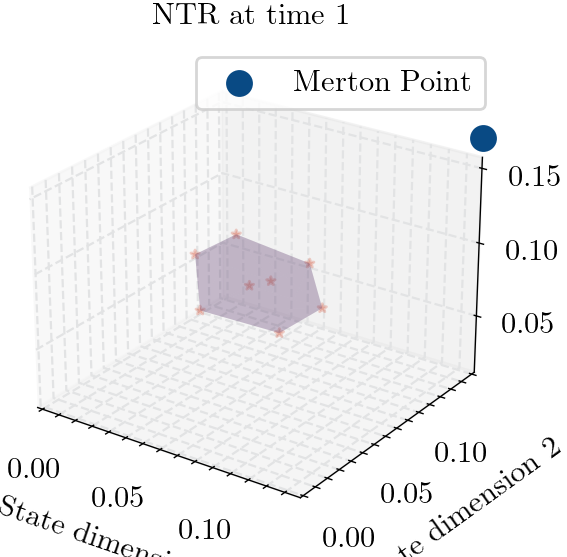

In [14]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def plot_ntr_at_time(NTR_history, t):
    hull = NTR_history[t]
    
    if hull is not None:
        vertices = hull.points  # Vertices are stored in the 'points' attribute of ConvexHull
        D = vertices.shape[1]  # Dimension of the state space
        plt.figure(figsize=(4,3),dpi=200)

        if D == 2:
            # 2D plot
            plt.fill(vertices[hull.vertices, 0], vertices[hull.vertices, 1], color = colors[1], alpha=0.2,label='NTR')
            plt.title(f'NTR at time {t}')
            plt.scatter(merton_p[0], merton_p[1],label='Merton Point')
            plt.legend()
            plt.xlabel('State dimension 1')
            plt.ylabel('State dimension 2')
            x_min, x_max = vertices[:, 0].min(), vertices[:, 0].max()
            y_min, y_max = vertices[:, 1].min(), vertices[:, 1].max()
            plt.xlim(x_min - 0.1, x_max + 0.1)
            plt.ylim(y_min - 0.1, y_max + 0.1)
            plt.grid(alpha=0.5)

        elif D == 3:
                # 3D plot
                ax = plt.axes(projection='3d')
                ax.scatter(vertices[:, 0], vertices[:, 1], vertices[:, 2], color=colors[1],alpha=0.2,s=10,marker='*')
                
                # Plot only the convex hull surfaces without edges
                faces = hull.simplices
                poly3d = [[vertices[face] for face in simplex] for simplex in faces]
                ax.add_collection3d(Poly3DCollection(poly3d, facecolors=colors[4], edgecolor='none', alpha=0.2))
                
                ax.scatter(merton_p[0], merton_p[1], merton_p[2], color=colors[0], s=75, label='Merton Point')
                ax.legend()
                ax.set_xlabel('State dimension 1')
                ax.set_ylabel('State dimension 2')
                ax.set_zlabel('State dimension 3')
                plt.title(f'NTR at time {t}')
                x_min, x_max = vertices[:, 0].min(), vertices[:, 0].max()
                y_min, y_max = vertices[:, 1].min(), vertices[:, 1].max()
                z_min, z_max = vertices[:, 2].min(), vertices[:, 2].max()
                ax.set_xlim(x_min - 0.05, x_max + 0.05)
                ax.set_ylim(y_min - 0.05, y_max + 0.05)
                ax.set_zlim(z_min - 0.05, z_max + 0.05)  
                ax.view_init(elev=25, azim=305)  # Adjust elev and azim for desired viewing angle

        plt.show()

    else:
        print(f"Not enough vertices to form an NTR at time {t}")

# Example: Plot NTR at time t=1
plot_ntr_at_time(NTR,int(T/Delta_t)-5)

/var/folders/hz/t94d7ym95fx1sf3fpl6b9bcm0000gn/T/ipykernel_4960/2251051234.py:75: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = plt.cm.get_cmap(cmap)


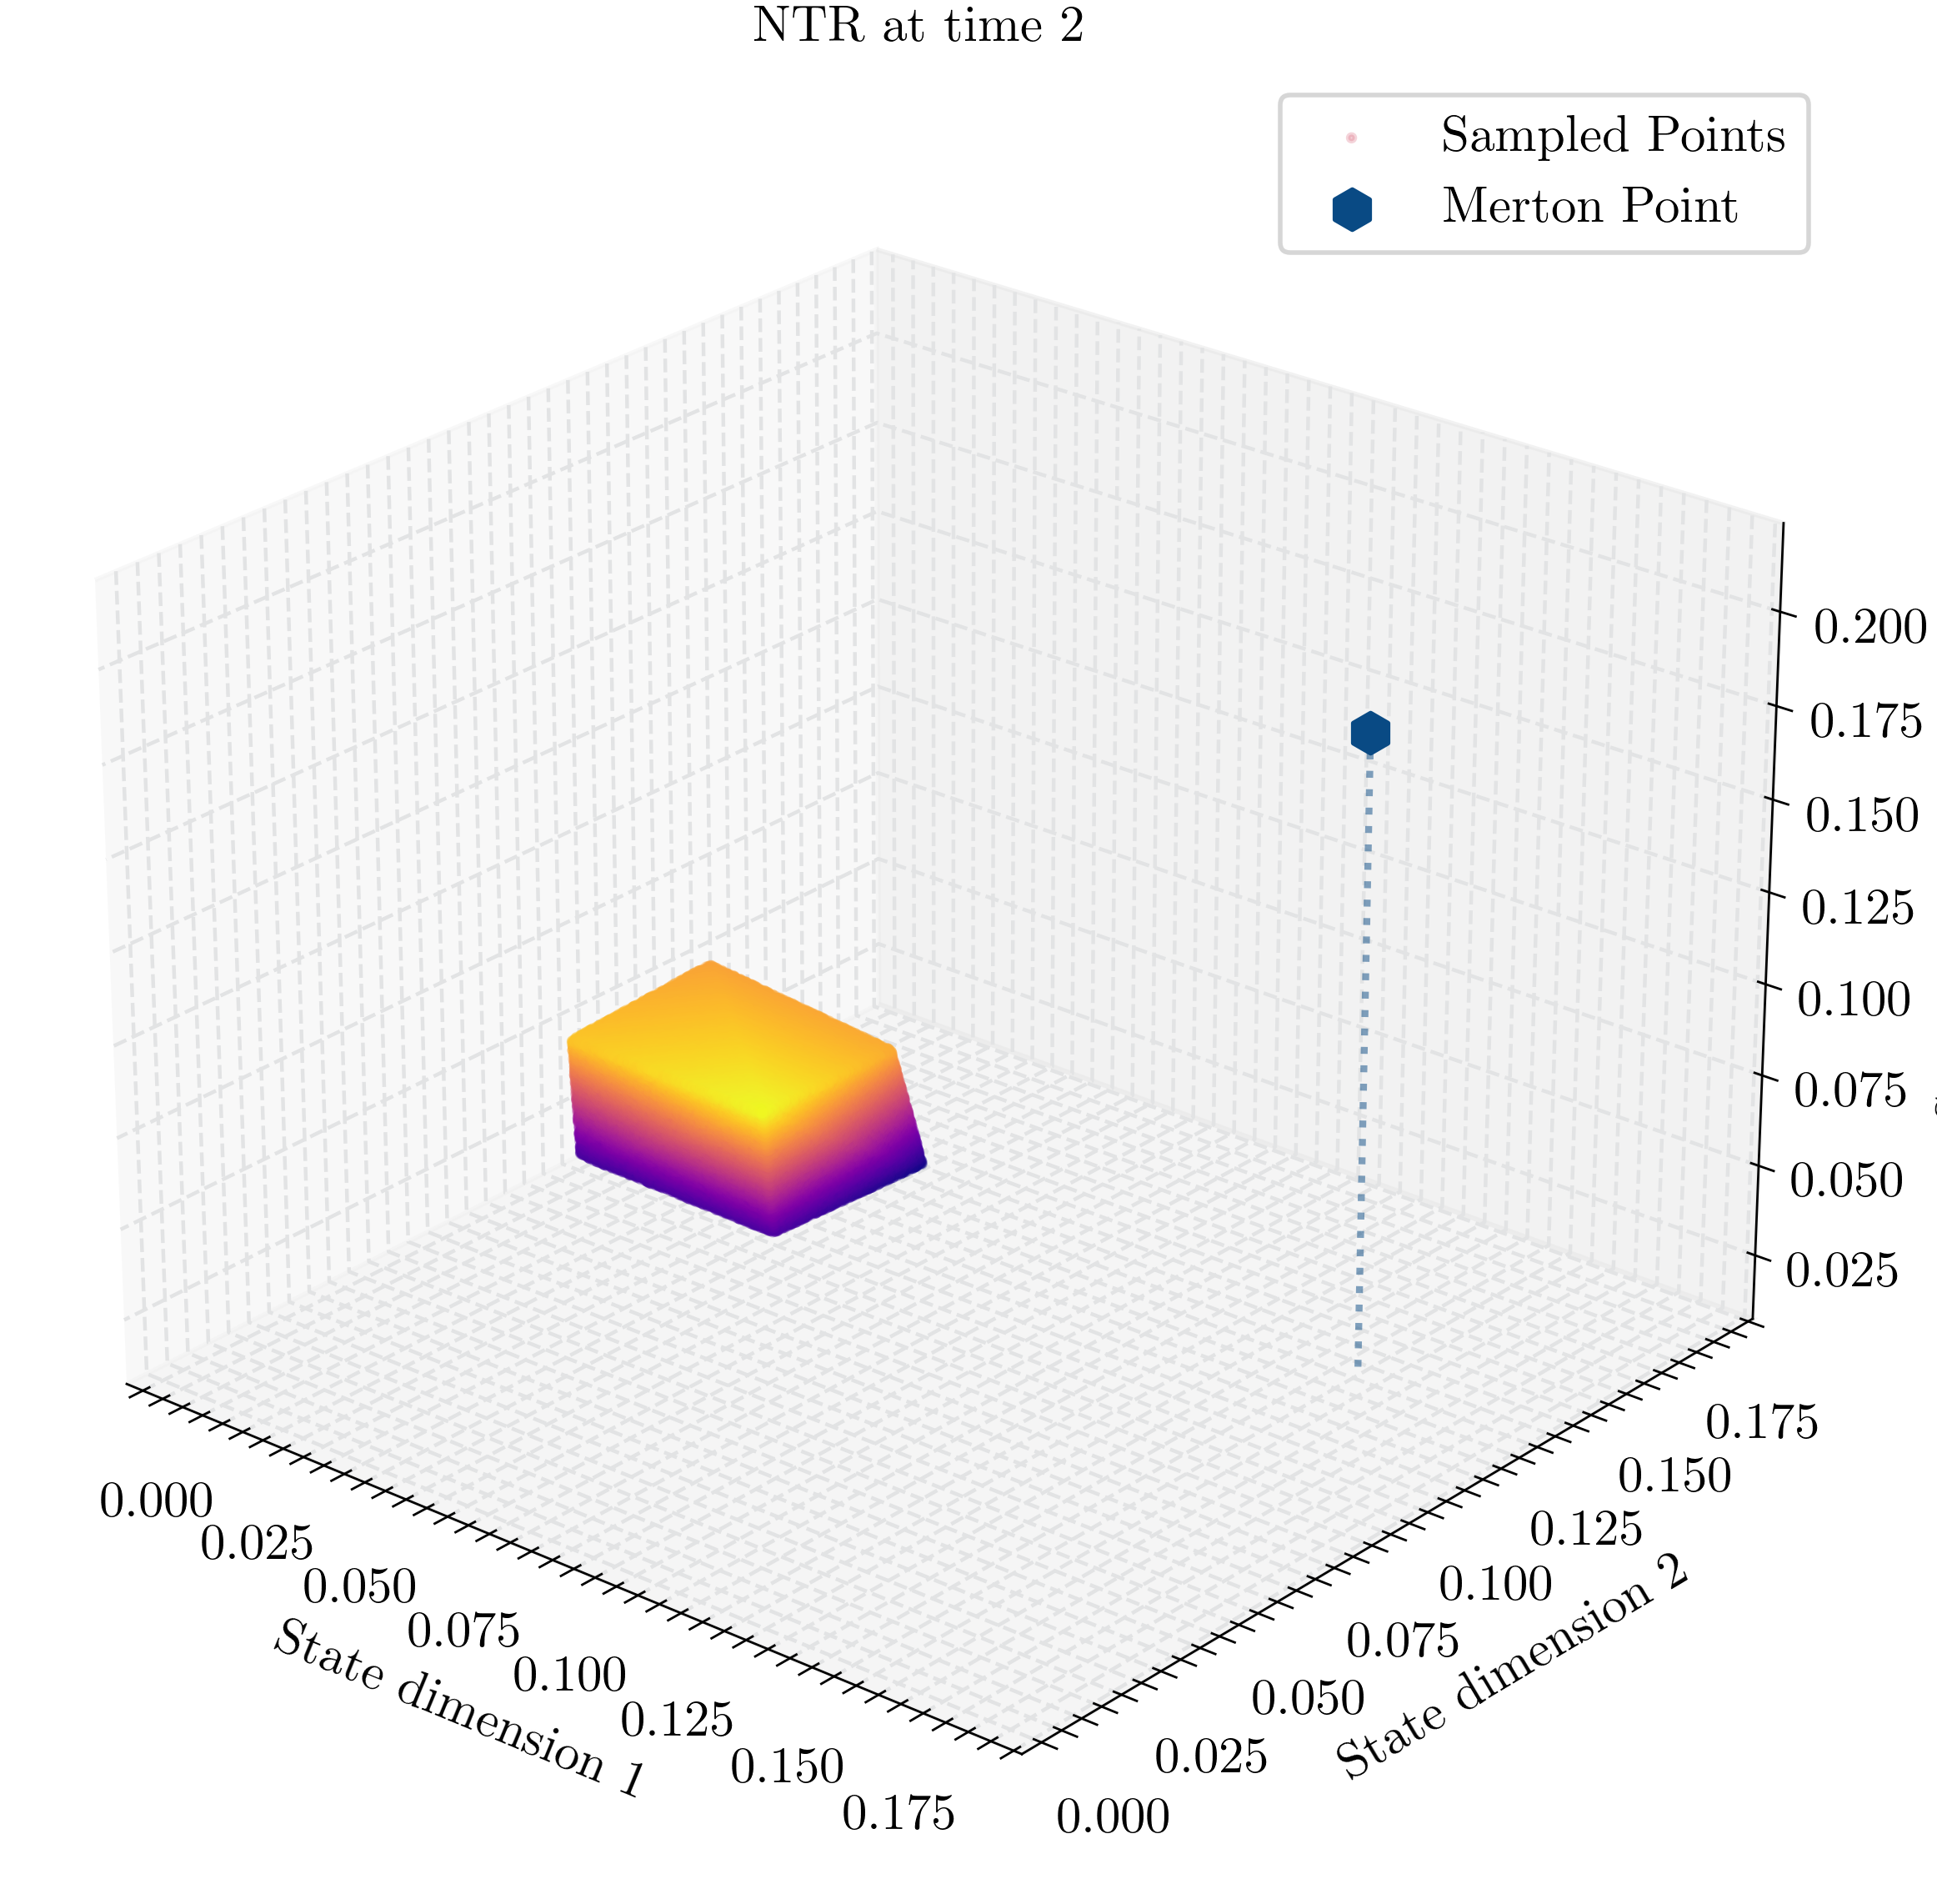

In [50]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from scipy.spatial import ConvexHull
import numpy as np

def sample_points_on_faces(vertices, faces, num_samples=5000):
    """
    Uniformly sample points on the faces of a convex hull.

    Parameters:
    - vertices: The vertices of the convex hull.
    - faces: The simplices (triangular faces) of the convex hull.
    - num_samples: Number of points to sample.

    Returns:
    - sampled_points: Array of sampled points on the hull's surfaces.
    - face_indices: Array of face indices corresponding to the sampled points.
    """
    sampled_points = []
    face_indices = []
    
    for i, simplex in enumerate(faces):
        # Get the vertices of the face
        face_vertices = vertices[simplex]

        # Generate random barycentric coordinates
        u = np.random.rand(num_samples, 1)
        v = np.random.rand(num_samples, 1)
        mask = u + v > 1
        u[mask] = 1 - u[mask]
        v[mask] = 1 - v[mask]
        w = 1 - u - v

        # Compute the sampled points using barycentric interpolation
        samples = u * face_vertices[0] + v * face_vertices[1] + w * face_vertices[2]
        sampled_points.append(samples)
        face_indices.extend([i] * num_samples)

    sampled_points = np.vstack(sampled_points)
    face_indices = np.array(face_indices)
    return sampled_points, face_indices


def plot_ntr_at_time_with_sampling(NTR_history, t, cmap='plasma', num_samples=5000):
    """
    Plots the NTR (No-Trade Region) in 3D with sampled points on the surfaces.

    Parameters:
    - NTR_history: List of ConvexHull objects representing the NTR at each time step.
    - t: Time step to plot.
    - colors: List of colors for visual elements (e.g., vertices, Merton point, etc.).
    - merton_p: Coordinates of the Merton point.
    - cmap: Colormap for face visualization.
    - num_samples: Number of points to sample on each face.
    """
    hull = NTR_history[t]
    
    if hull is not None:
        vertices = hull.points
        D = vertices.shape[1]
        plt.figure(figsize=(8, 6), dpi=400)

        if D == 3:
            # 3D plot
            ax = plt.axes(projection='3d')
            # ax.scatter(vertices[:, 0], vertices[:, 1], vertices[:, 2], color=colors[1], alpha=0.5, s=10, marker='o')

            # Sample points on the faces
            faces = hull.simplices
            sampled_points, face_indices = sample_points_on_faces(vertices, faces, num_samples=num_samples)

            # Calculate color values for the sampled points
            z_values = sampled_points[:, 2]  # Use z-coordinates for coloring
            norm = plt.Normalize(vmin=z_values.min(), vmax=z_values.max())
            colormap = plt.cm.get_cmap(cmap)
            face_colors = colormap(norm(z_values))

            # Plot sampled points with colormap
            ax.scatter(
                sampled_points[:, 0], sampled_points[:, 1], sampled_points[:, 2],
                color=face_colors, alpha=0.25, s=2, label='Sampled Points'
            )

            # Highlight the Merton point and add a stem
            ax.scatter(
                merton_p[0], merton_p[1], merton_p[2], marker='h',
                color=colors[0], s=75, label='Merton Point'
            )
            ax.plot(
                [merton_p[0], merton_p[0]],  # x-coordinates
                [merton_p[1], merton_p[1]],  # y-coordinates
                [0, merton_p[2]],            # z-coordinates (from base to the point)
                color=colors[0], linestyle='dotted', linewidth=1.5,alpha=0.5
            )


            # Set axis labels and limits
            ax.set_xlabel('State dimension 1')
            ax.set_ylabel('State dimension 2')
            ax.set_zlabel('State dimension 3')
            plt.title(f'NTR at time {t}')
            x_min, x_max = vertices[:, 0].min(), vertices[:, 0].max()
            y_min, y_max = vertices[:, 1].min(), vertices[:, 1].max()
            z_min, z_max = vertices[:, 2].min(), vertices[:, 2].max()

            # If merton point has higer max value use that
            if merton_p is not None:
                x_max = max(x_max, merton_p[0])
                y_max = max(y_max, merton_p[1])
                z_max = max(z_max, merton_p[2])

            ax.set_xlim(x_min - 0.05, x_max + 0.05)
            ax.set_ylim(y_min - 0.05, y_max + 0.05)
            ax.set_zlim(z_min - 0.05, z_max + 0.05)
            ax.view_init(elev=25, azim=310)
            ax.legend()

        plt.show()

    else:
        print(f"Not enough vertices to form an NTR at time {t}")

plot_ntr_at_time_with_sampling(NTR,int(T/Delta_t)-4)

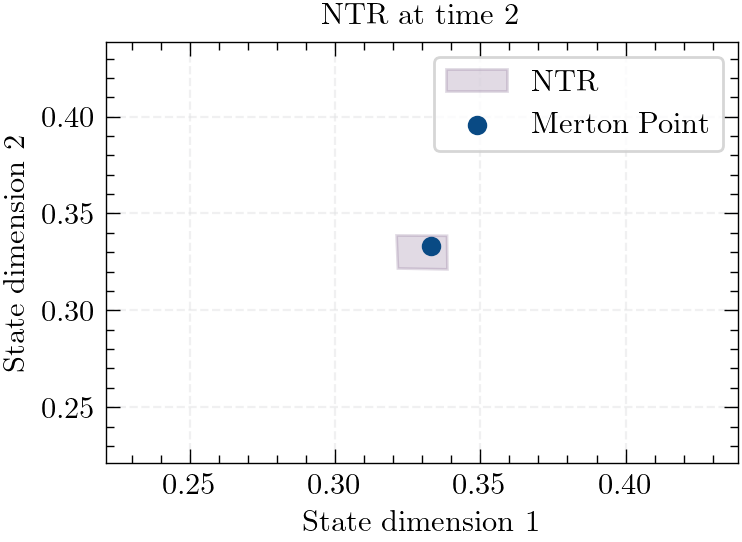

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def plot_ntr_at_time(NTR_history, t):
    hull = NTR_history[t]
    
    if hull is not None:
        vertices = hull.points  # Vertices are stored in the 'points' attribute of ConvexHull
        D = vertices.shape[1]  # Dimension of the state space
        plt.figure(figsize=(4,3),dpi=200)

        if D == 2:
            # 2D plot
            plt.fill(vertices[hull.vertices, 0], vertices[hull.vertices, 1], color = colors[1], alpha=0.2,label='NTR')
            plt.title(f'NTR at time {t}')
            plt.scatter(merton_p[0], merton_p[1],label='Merton Point')
            plt.legend()
            plt.xlabel('State dimension 1')
            plt.ylabel('State dimension 2')
            x_min, x_max = vertices[:, 0].min(), vertices[:, 0].max()
            y_min, y_max = vertices[:, 1].min(), vertices[:, 1].max()
            plt.xlim(x_min - 0.1, x_max + 0.1)
            plt.ylim(y_min - 0.1, y_max + 0.1)
            plt.grid(alpha=0.5)
        elif D == 3:
            # 3D plot
            ax = plt.axes(projection='3d')
            ax.scatter(vertices[:, 0], vertices[:, 1], vertices[:, 2], color='red')
            ax.add_collection3d(Poly3DCollection(vertices[hull.simplices], facecolors='lightgray', edgecolors='k', alpha=0.4))
            ax.scatter(merton_p[0], merton_p[1], merton_p[2], color='blue', s=100, label='Merton Point')
            ax.legend()
            ax.set_xlabel('State dimension 1')
            ax.set_ylabel('State dimension 2')
            ax.set_zlabel('State dimension 3')
            plt.title(f'NTR at time {t}')
            x_min, x_max = vertices[:, 0].min(), vertices[:, 0].max()
            y_min, y_max = vertices[:, 1].min(), vertices[:, 1].max()
            z_min, z_max = vertices[:, 2].min(), vertices[:, 2].max()
            ax.set_xlim(x_min - 0.05, x_max + 0.05)
            ax.set_ylim(y_min - 0.1, y_max + 0.1)
            ax.set_zlim(z_min - 0.1, z_max + 0.1)
        plt.show()

    else:
        print(f"Not enough vertices to form an NTR at time {t}")

# Example: Plot NTR at time t=1
# plot_ntr_at_time(NTR,int(T/Delta_t)-2)
def plot_ntr_at_time_select_dims(NTR_history, t, dims=(0, 1)):
    hull = NTR_history[t]
    
    if hull is not None:
        vertices = hull.points  # Vertices are stored in the 'points' attribute of ConvexHull
        D = vertices.shape[1]  # Dimension of the state space
        plt.figure(figsize=(4,3),dpi=200)

        if D == 2:
            # 2D plot
            plt.fill(vertices[hull.vertices, 0], vertices[hull.vertices, 1], color = colors[4], alpha=0.2,label='NTR')
            plt.title(f'NTR at time {t}')
            plt.scatter(merton_p[0], merton_p[1],label='Merton Point')
            plt.legend()
            plt.xlabel('State dimension 1')
            plt.ylabel('State dimension 2')
            x_min, x_max = vertices[:, 0].min(), vertices[:, 0].max()
            y_min, y_max = vertices[:, 1].min(), vertices[:, 1].max()
            plt.xlim(x_min - 0.1, x_max + 0.1)
            plt.ylim(y_min - 0.1, y_max + 0.1)
            plt.grid(alpha=0.5)
        elif D >= 3:
            # Select dimensions to plot
            vertices_2d = vertices[:, dims]
            hull_2d = ConvexHull(vertices_2d)
            plt.fill(vertices_2d[hull_2d.vertices, 0], vertices_2d[hull_2d.vertices, 1], color = colors[4], alpha=0.2,label='NTR')
            plt.title(f'NTR at time {t}')
            plt.scatter(merton_p[dims[0]], merton_p[dims[1]],label='Merton Point')
            plt.legend()
            plt.xlabel(f'State dimension {dims[0]}')
            plt.ylabel(f'State dimension {dims[1]}')
            x_min, x_max = vertices_2d[:, 0].min(), vertices_2d[:, 0].max()
            y_min, y_max = vertices_2d[:, 1].min(), vertices_2d[:, 1].max()
            plt.xlim(x_min - 0.1, x_max + 0.1)
            plt.ylim(y_min - 0.1, y_max + 0.1)
            plt.grid(alpha=0.5)
        plt.show()

    else:
        print(f"Not enough vertices to form an NTR at time {t}")

# Example: Plot NTR at time t=1, selecting dimensions 0 and 2
plot_ntr_at_time_select_dims(NTR, int(T/Delta_t)-4, dims=(1, 2))